In [1]:
import numpy as np
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.multiprocessing as mp
from datetime import datetime

import pdb

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Utils
import data_generator
from model import VariationalLayer, VariationalNet

from train import TrainDecoupledElbo

In [2]:
is_cuda = False
dev = torch.device('cpu')  
if torch.cuda.is_available():
    is_cuda = True
    dev = torch.device('cuda')  

In [3]:
# Setting the seeds to allow replication
# Changing the seed might require hyperparameter tuning again
# Because it changes the deterministic parameters
seed_number = 0
np.random.seed(seed_number)
torch.manual_seed(seed_number)
random.seed(seed_number)

In [4]:
# Setting parameters
N = 10000 # Total data size
N_train = 6000 # Training data size
K = 1/500 # Regularization parameter (ELBO)
PLV = 0.5 # Variance of prior gaussian 
N_SAMPLES = 16 # Sampling size while training
BATCH_SIZE_LOADER = 32 # Standard batch size

In [5]:
N_valid = N - N_train

X, y = data_generator.data_1to1(N)
X, y_perfect = data_generator.data_1to1(N, noise_level=1)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

dataset = data_generator.ArtificialDataset(X, y)

data_train, data_valid = torch.utils.data.random_split(
    dataset, [N_train, N_valid], generator=torch.manual_seed(seed_number))

training_loader = torch.utils.data.DataLoader(
    data_train, batch_size=BATCH_SIZE_LOADER,
    shuffle=False, num_workers=mp.cpu_count())

validation_loader = torch.utils.data.DataLoader(
    data_valid, batch_size=BATCH_SIZE_LOADER,
    shuffle=False, num_workers=mp.cpu_count())

input_size = X.shape[1]
output_size = y.shape[1]

In [6]:
h = VariationalNet(N_SAMPLES, input_size, output_size, PLV).to(dev)
opt_h = torch.optim.Adam(h.parameters(), lr=0.005)
mse_loss_mean = nn.MSELoss(reduction='mean')

train_elbo = TrainDecoupledElbo(
                model=h,
                opt=opt_h,
                loss_data=mse_loss_mean,
                K=K,
                training_loader=training_loader,
                validation_loader=validation_loader
            )

In [7]:
train_elbo.train(EPOCHS=100)

------------------EPOCH 1------------------
DATA LOSS 	 train 1.48 valid 0.54
KL LOSS 	 train 1.39 valid 1.37
ELBO LOSS 	 train 2.87 valid 1.91
------------------EPOCH 2------------------
DATA LOSS 	 train 0.49 valid 0.49
KL LOSS 	 train 1.32 valid 1.28
ELBO LOSS 	 train 1.81 valid 1.77
------------------EPOCH 3------------------
DATA LOSS 	 train 0.46 valid 0.47
KL LOSS 	 train 1.24 valid 1.19
ELBO LOSS 	 train 1.7 valid 1.67
------------------EPOCH 4------------------
DATA LOSS 	 train 0.45 valid 0.46
KL LOSS 	 train 1.17 valid 1.13
ELBO LOSS 	 train 1.61 valid 1.59
------------------EPOCH 5------------------
DATA LOSS 	 train 0.43 valid 0.44
KL LOSS 	 train 1.11 valid 1.09
ELBO LOSS 	 train 1.55 valid 1.53
------------------EPOCH 6------------------
DATA LOSS 	 train 0.42 valid 0.43
KL LOSS 	 train 1.08 valid 1.06
ELBO LOSS 	 train 1.5 valid 1.49
------------------EPOCH 7------------------
DATA LOSS 	 train 0.41 valid 0.42
KL LOSS 	 train 1.05 valid 1.04
ELBO LOSS 	 train 1.46 valid

DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.97 valid 0.97
ELBO LOSS 	 train 1.22 valid 1.22
------------------EPOCH 59------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.98 valid 0.97
ELBO LOSS 	 train 1.22 valid 1.22
------------------EPOCH 60------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.98 valid 0.97
ELBO LOSS 	 train 1.22 valid 1.22
------------------EPOCH 61------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.98 valid 0.98
ELBO LOSS 	 train 1.22 valid 1.22
------------------EPOCH 62------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.98 valid 0.98
ELBO LOSS 	 train 1.22 valid 1.23
------------------EPOCH 63------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.98 valid 0.97
ELBO LOSS 	 train 1.22 valid 1.22
------------------EPOCH 64------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.98 valid 0.99
ELBO LOSS 	 train 1.22 valid 1.23
------------------EPOCH 65----

In [13]:
Kstr = str(K).replace('.','')
plvstr = str(PLV).replace('.','')
torch.save(train_elbo.model, f'./models/elbo_nv1_{Kstr}_{plvstr}.pkl')

In [ ]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0001 -1

In [11]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0003 -1

------------------EPOCH 1------------------
DATA LOSS 	 train 1.48 valid 0.54
KL LOSS 	 train 0.18 valid 0.19
ELBO LOSS 	 train 1.66 valid 0.74
------------------EPOCH 2------------------
DATA LOSS 	 train 0.49 valid 0.49
KL LOSS 	 train 0.19 valid 0.19
ELBO LOSS 	 train 0.68 valid 0.68
------------------EPOCH 3------------------
DATA LOSS 	 train 0.46 valid 0.47
KL LOSS 	 train 0.19 valid 0.19
ELBO LOSS 	 train 0.65 valid 0.66
------------------EPOCH 4------------------
DATA LOSS 	 train 0.45 valid 0.46
KL LOSS 	 train 0.19 valid 0.19
ELBO LOSS 	 train 0.63 valid 0.64
------------------EPOCH 5------------------
DATA LOSS 	 train 0.43 valid 0.44
KL LOSS 	 train 0.19 valid 0.19
ELBO LOSS 	 train 0.62 valid 0.63
------------------EPOCH 6------------------
DATA LOSS 	 train 0.42 valid 0.43
KL LOSS 	 train 0.19 valid 0.19
ELBO LOSS 	 train 0.61 valid 0.62
------------------EPOCH 7------------------
DATA LOSS 	 train 0.41 valid 0.42
KL LOSS 	 train 0.2 valid 0.2
ELBO LOSS 	 train 0.6 valid 

DATA LOSS 	 train 0.22 valid 0.23
KL LOSS 	 train 0.39 valid 0.39
ELBO LOSS 	 train 0.6 valid 0.61
------------------EPOCH 59------------------
DATA LOSS 	 train 0.22 valid 0.23
KL LOSS 	 train 0.39 valid 0.39
ELBO LOSS 	 train 0.6 valid 0.61
------------------EPOCH 60------------------
DATA LOSS 	 train 0.22 valid 0.23
KL LOSS 	 train 0.39 valid 0.39
ELBO LOSS 	 train 0.6 valid 0.61
------------------EPOCH 61------------------
DATA LOSS 	 train 0.21 valid 0.23
KL LOSS 	 train 0.39 valid 0.39
ELBO LOSS 	 train 0.6 valid 0.61
------------------EPOCH 62------------------
DATA LOSS 	 train 0.21 valid 0.23
KL LOSS 	 train 0.39 valid 0.39
ELBO LOSS 	 train 0.6 valid 0.61
------------------EPOCH 63------------------
DATA LOSS 	 train 0.21 valid 0.23
KL LOSS 	 train 0.39 valid 0.39
ELBO LOSS 	 train 0.6 valid 0.61
------------------EPOCH 64------------------
DATA LOSS 	 train 0.21 valid 0.23
KL LOSS 	 train 0.39 valid 0.39
ELBO LOSS 	 train 0.6 valid 0.61
------------------EPOCH 65-----------

In [12]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.001 -1

------------------EPOCH 1------------------
DATA LOSS 	 train 1.47 valid 0.53
KL LOSS 	 train 0.6 valid 0.64
ELBO LOSS 	 train 2.07 valid 1.17
------------------EPOCH 2------------------
DATA LOSS 	 train 0.49 valid 0.49
KL LOSS 	 train 0.63 valid 0.62
ELBO LOSS 	 train 1.12 valid 1.11
------------------EPOCH 3------------------
DATA LOSS 	 train 0.46 valid 0.47
KL LOSS 	 train 0.62 valid 0.61
ELBO LOSS 	 train 1.08 valid 1.08
------------------EPOCH 4------------------
DATA LOSS 	 train 0.45 valid 0.46
KL LOSS 	 train 0.61 valid 0.6
ELBO LOSS 	 train 1.06 valid 1.06
------------------EPOCH 5------------------
DATA LOSS 	 train 0.44 valid 0.45
KL LOSS 	 train 0.6 valid 0.6
ELBO LOSS 	 train 1.04 valid 1.05
------------------EPOCH 6------------------
DATA LOSS 	 train 0.42 valid 0.43
KL LOSS 	 train 0.61 valid 0.61
ELBO LOSS 	 train 1.03 valid 1.05
------------------EPOCH 7------------------
DATA LOSS 	 train 0.41 valid 0.42
KL LOSS 	 train 0.62 valid 0.62
ELBO LOSS 	 train 1.03 valid 1

DATA LOSS 	 train 0.22 valid 0.23
KL LOSS 	 train 1.23 valid 1.23
ELBO LOSS 	 train 1.45 valid 1.46
------------------EPOCH 59------------------
DATA LOSS 	 train 0.22 valid 0.23
KL LOSS 	 train 1.23 valid 1.23
ELBO LOSS 	 train 1.45 valid 1.46
------------------EPOCH 60------------------
DATA LOSS 	 train 0.22 valid 0.22
KL LOSS 	 train 1.24 valid 1.24
ELBO LOSS 	 train 1.46 valid 1.46
------------------EPOCH 61------------------
DATA LOSS 	 train 0.22 valid 0.23
KL LOSS 	 train 1.24 valid 1.24
ELBO LOSS 	 train 1.46 valid 1.47
------------------EPOCH 62------------------
DATA LOSS 	 train 0.22 valid 0.22
KL LOSS 	 train 1.25 valid 1.25
ELBO LOSS 	 train 1.46 valid 1.47
------------------EPOCH 63------------------
DATA LOSS 	 train 0.22 valid 0.22
KL LOSS 	 train 1.25 valid 1.25
ELBO LOSS 	 train 1.47 valid 1.48
------------------EPOCH 64------------------
DATA LOSS 	 train 0.22 valid 0.22
KL LOSS 	 train 1.25 valid 1.26
ELBO LOSS 	 train 1.47 valid 1.48
------------------EPOCH 65----

In [13]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.003 -1

------------------EPOCH 1------------------
DATA LOSS 	 train 1.47 valid 0.53
KL LOSS 	 train 1.79 valid 1.89
ELBO LOSS 	 train 3.26 valid 2.42
------------------EPOCH 2------------------
DATA LOSS 	 train 0.49 valid 0.49
KL LOSS 	 train 1.85 valid 1.8
ELBO LOSS 	 train 2.34 valid 2.29
------------------EPOCH 3------------------
DATA LOSS 	 train 0.47 valid 0.48
KL LOSS 	 train 1.76 valid 1.71
ELBO LOSS 	 train 2.23 valid 2.19
------------------EPOCH 4------------------
DATA LOSS 	 train 0.45 valid 0.46
KL LOSS 	 train 1.69 valid 1.67
ELBO LOSS 	 train 2.15 valid 2.13
------------------EPOCH 5------------------
DATA LOSS 	 train 0.44 valid 0.45
KL LOSS 	 train 1.67 valid 1.67
ELBO LOSS 	 train 2.11 valid 2.11
------------------EPOCH 6------------------
DATA LOSS 	 train 0.42 valid 0.43
KL LOSS 	 train 1.68 valid 1.68
ELBO LOSS 	 train 2.1 valid 2.11
------------------EPOCH 7------------------
DATA LOSS 	 train 0.41 valid 0.42
KL LOSS 	 train 1.69 valid 1.7
ELBO LOSS 	 train 2.11 valid 

DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 2.65 valid 2.65
ELBO LOSS 	 train 2.9 valid 2.9
------------------EPOCH 59------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 2.66 valid 2.63
ELBO LOSS 	 train 2.9 valid 2.88
------------------EPOCH 60------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 2.66 valid 2.66
ELBO LOSS 	 train 2.9 valid 2.91
------------------EPOCH 61------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 2.66 valid 2.67
ELBO LOSS 	 train 2.9 valid 2.91
------------------EPOCH 62------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 2.67 valid 2.68
ELBO LOSS 	 train 2.91 valid 2.92
------------------EPOCH 63------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 2.67 valid 2.67
ELBO LOSS 	 train 2.92 valid 2.92
------------------EPOCH 64------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 2.67 valid 2.66
ELBO LOSS 	 train 2.92 valid 2.91
------------------EPOCH 65---------

In [14]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.01 -1

------------------EPOCH 1------------------
DATA LOSS 	 train 1.46 valid 0.53
KL LOSS 	 train 5.88 valid 6.08
ELBO LOSS 	 train 7.34 valid 6.61
------------------EPOCH 2------------------
DATA LOSS 	 train 0.49 valid 0.49
KL LOSS 	 train 5.82 valid 5.54
ELBO LOSS 	 train 6.3 valid 6.03
------------------EPOCH 3------------------
DATA LOSS 	 train 0.46 valid 0.48
KL LOSS 	 train 5.31 valid 5.04
ELBO LOSS 	 train 5.78 valid 5.52
------------------EPOCH 4------------------
DATA LOSS 	 train 0.45 valid 0.46
KL LOSS 	 train 4.89 valid 4.74
ELBO LOSS 	 train 5.34 valid 5.2
------------------EPOCH 5------------------
DATA LOSS 	 train 0.44 valid 0.45
KL LOSS 	 train 4.67 valid 4.6
ELBO LOSS 	 train 5.11 valid 5.05
------------------EPOCH 6------------------
DATA LOSS 	 train 0.43 valid 0.44
KL LOSS 	 train 4.58 valid 4.57
ELBO LOSS 	 train 5.01 valid 5.0
------------------EPOCH 7------------------
DATA LOSS 	 train 0.42 valid 0.42
KL LOSS 	 train 4.59 valid 4.66
ELBO LOSS 	 train 5.01 valid 5

DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 5.75 valid 5.69
ELBO LOSS 	 train 6.0 valid 5.95
------------------EPOCH 59------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 5.73 valid 5.69
ELBO LOSS 	 train 5.98 valid 5.95
------------------EPOCH 60------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 5.73 valid 5.75
ELBO LOSS 	 train 5.98 valid 6.0
------------------EPOCH 61------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 5.72 valid 5.67
ELBO LOSS 	 train 5.96 valid 5.93
------------------EPOCH 62------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 5.7 valid 5.65
ELBO LOSS 	 train 5.95 valid 5.91
------------------EPOCH 63------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 5.69 valid 5.71
ELBO LOSS 	 train 5.94 valid 5.98
------------------EPOCH 64------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 5.68 valid 5.65
ELBO LOSS 	 train 5.93 valid 5.9
------------------EPOCH 65--------

In [15]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.03 -1

------------------EPOCH 1------------------
DATA LOSS 	 train 1.46 valid 0.53
KL LOSS 	 train 17.14 valid 17.18
ELBO LOSS 	 train 18.6 valid 17.71
------------------EPOCH 2------------------
DATA LOSS 	 train 0.49 valid 0.49
KL LOSS 	 train 15.85 valid 14.54
ELBO LOSS 	 train 16.34 valid 15.03
------------------EPOCH 3------------------
DATA LOSS 	 train 0.47 valid 0.48
KL LOSS 	 train 13.46 valid 12.33
ELBO LOSS 	 train 13.93 valid 12.81
------------------EPOCH 4------------------
DATA LOSS 	 train 0.45 valid 0.47
KL LOSS 	 train 11.72 valid 11.15
ELBO LOSS 	 train 12.17 valid 11.61
------------------EPOCH 5------------------
DATA LOSS 	 train 0.44 valid 0.45
KL LOSS 	 train 10.88 valid 10.67
ELBO LOSS 	 train 11.33 valid 11.13
------------------EPOCH 6------------------
DATA LOSS 	 train 0.43 valid 0.44
KL LOSS 	 train 10.55 valid 10.48
ELBO LOSS 	 train 10.98 valid 10.92
------------------EPOCH 7------------------
DATA LOSS 	 train 0.42 valid 0.42
KL LOSS 	 train 10.46 valid 10.59
E

DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 11.43 valid 11.34
ELBO LOSS 	 train 11.69 valid 11.62
------------------EPOCH 57------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 11.37 valid 11.37
ELBO LOSS 	 train 11.64 valid 11.64
------------------EPOCH 58------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 11.35 valid 11.22
ELBO LOSS 	 train 11.62 valid 11.49
------------------EPOCH 59------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 11.29 valid 11.16
ELBO LOSS 	 train 11.56 valid 11.43
------------------EPOCH 60------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 11.26 valid 11.28
ELBO LOSS 	 train 11.53 valid 11.55
------------------EPOCH 61------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 11.18 valid 11.1
ELBO LOSS 	 train 11.44 valid 11.37
------------------EPOCH 62------------------
DATA LOSS 	 train 0.26 valid 0.28
KL LOSS 	 train 11.14 valid 11.06
ELBO LOSS 	 train 11.41 valid 11.33
---

In [16]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.1 -1

------------------EPOCH 1------------------
DATA LOSS 	 train 1.49 valid 0.54
KL LOSS 	 train 54.75 valid 52.53
ELBO LOSS 	 train 56.24 valid 53.07
------------------EPOCH 2------------------
DATA LOSS 	 train 0.5 valid 0.5
KL LOSS 	 train 46.0 valid 39.78
ELBO LOSS 	 train 46.49 valid 40.29
------------------EPOCH 3------------------
DATA LOSS 	 train 0.48 valid 0.49
KL LOSS 	 train 34.83 valid 30.0
ELBO LOSS 	 train 35.31 valid 30.5
------------------EPOCH 4------------------
DATA LOSS 	 train 0.47 valid 0.47
KL LOSS 	 train 27.5 valid 25.43
ELBO LOSS 	 train 27.97 valid 25.9
------------------EPOCH 5------------------
DATA LOSS 	 train 0.45 valid 0.46
KL LOSS 	 train 24.63 valid 24.01
ELBO LOSS 	 train 25.08 valid 24.46
------------------EPOCH 6------------------
DATA LOSS 	 train 0.43 valid 0.44
KL LOSS 	 train 23.67 valid 23.27
ELBO LOSS 	 train 24.1 valid 23.71
------------------EPOCH 7------------------
DATA LOSS 	 train 0.42 valid 0.43
KL LOSS 	 train 23.31 valid 23.39
ELBO LOS

DATA LOSS 	 train 0.31 valid 0.32
KL LOSS 	 train 20.62 valid 20.71
ELBO LOSS 	 train 20.93 valid 21.03
------------------EPOCH 57------------------
DATA LOSS 	 train 0.31 valid 0.32
KL LOSS 	 train 20.67 valid 20.6
ELBO LOSS 	 train 20.99 valid 20.93
------------------EPOCH 58------------------
DATA LOSS 	 train 0.31 valid 0.32
KL LOSS 	 train 20.67 valid 20.53
ELBO LOSS 	 train 20.99 valid 20.85
------------------EPOCH 59------------------
DATA LOSS 	 train 0.31 valid 0.32
KL LOSS 	 train 20.59 valid 20.69
ELBO LOSS 	 train 20.9 valid 21.01
------------------EPOCH 60------------------
DATA LOSS 	 train 0.31 valid 0.32
KL LOSS 	 train 20.61 valid 20.73
ELBO LOSS 	 train 20.92 valid 21.06
------------------EPOCH 61------------------
DATA LOSS 	 train 0.31 valid 0.32
KL LOSS 	 train 20.54 valid 20.56
ELBO LOSS 	 train 20.85 valid 20.89
------------------EPOCH 62------------------
DATA LOSS 	 train 0.31 valid 0.33
KL LOSS 	 train 20.57 valid 20.38
ELBO LOSS 	 train 20.88 valid 20.71
----

In [17]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0001 0

------------------EPOCH 1------------------
DATA LOSS 	 train 1.46 valid 0.52
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 1.52 valid 0.59
------------------EPOCH 2------------------
DATA LOSS 	 train 0.48 valid 0.48
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.55 valid 0.55
------------------EPOCH 3------------------
DATA LOSS 	 train 0.46 valid 0.47
KL LOSS 	 train 0.07 valid 0.06
ELBO LOSS 	 train 0.53 valid 0.53
------------------EPOCH 4------------------
DATA LOSS 	 train 0.45 valid 0.45
KL LOSS 	 train 0.06 valid 0.06
ELBO LOSS 	 train 0.51 valid 0.52
------------------EPOCH 5------------------
DATA LOSS 	 train 0.43 valid 0.44
KL LOSS 	 train 0.06 valid 0.06
ELBO LOSS 	 train 0.5 valid 0.5
------------------EPOCH 6------------------
DATA LOSS 	 train 0.42 valid 0.42
KL LOSS 	 train 0.06 valid 0.06
ELBO LOSS 	 train 0.48 valid 0.49
------------------EPOCH 7------------------
DATA LOSS 	 train 0.4 valid 0.4
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.47 valid 0

DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.08 valid 0.08
ELBO LOSS 	 train 0.32 valid 0.33
------------------EPOCH 59------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.08 valid 0.08
ELBO LOSS 	 train 0.32 valid 0.33
------------------EPOCH 60------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.08 valid 0.08
ELBO LOSS 	 train 0.32 valid 0.33
------------------EPOCH 61------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.08 valid 0.08
ELBO LOSS 	 train 0.32 valid 0.33
------------------EPOCH 62------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.08 valid 0.08
ELBO LOSS 	 train 0.32 valid 0.33
------------------EPOCH 63------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.08 valid 0.08
ELBO LOSS 	 train 0.32 valid 0.33
------------------EPOCH 64------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.08 valid 0.09
ELBO LOSS 	 train 0.32 valid 0.33
------------------EPOCH 65----

In [18]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0003 0

------------------EPOCH 1------------------
DATA LOSS 	 train 1.46 valid 0.52
KL LOSS 	 train 0.2 valid 0.2
ELBO LOSS 	 train 1.65 valid 0.72
------------------EPOCH 2------------------
DATA LOSS 	 train 0.48 valid 0.48
KL LOSS 	 train 0.2 valid 0.19
ELBO LOSS 	 train 0.67 valid 0.67
------------------EPOCH 3------------------
DATA LOSS 	 train 0.45 valid 0.46
KL LOSS 	 train 0.19 valid 0.19
ELBO LOSS 	 train 0.64 valid 0.65
------------------EPOCH 4------------------
DATA LOSS 	 train 0.44 valid 0.45
KL LOSS 	 train 0.19 valid 0.18
ELBO LOSS 	 train 0.62 valid 0.63
------------------EPOCH 5------------------
DATA LOSS 	 train 0.42 valid 0.43
KL LOSS 	 train 0.18 valid 0.18
ELBO LOSS 	 train 0.61 valid 0.62
------------------EPOCH 6------------------
DATA LOSS 	 train 0.4 valid 0.4
KL LOSS 	 train 0.19 valid 0.19
ELBO LOSS 	 train 0.59 valid 0.59
------------------EPOCH 7------------------
DATA LOSS 	 train 0.37 valid 0.36
KL LOSS 	 train 0.19 valid 0.19
ELBO LOSS 	 train 0.56 valid 0.

DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.24 valid 0.25
ELBO LOSS 	 train 0.48 valid 0.49
------------------EPOCH 59------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.25 valid 0.25
ELBO LOSS 	 train 0.48 valid 0.49
------------------EPOCH 60------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.25 valid 0.25
ELBO LOSS 	 train 0.48 valid 0.49
------------------EPOCH 61------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.25 valid 0.25
ELBO LOSS 	 train 0.48 valid 0.49
------------------EPOCH 62------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.25 valid 0.25
ELBO LOSS 	 train 0.48 valid 0.49
------------------EPOCH 63------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.25 valid 0.25
ELBO LOSS 	 train 0.48 valid 0.49
------------------EPOCH 64------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.25 valid 0.25
ELBO LOSS 	 train 0.48 valid 0.49
------------------EPOCH 65----

In [19]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.001 0

------------------EPOCH 1------------------
DATA LOSS 	 train 1.48 valid 0.54
KL LOSS 	 train 0.65 valid 0.65
ELBO LOSS 	 train 2.13 valid 1.19
------------------EPOCH 2------------------
DATA LOSS 	 train 0.49 valid 0.49
KL LOSS 	 train 0.63 valid 0.61
ELBO LOSS 	 train 1.11 valid 1.1
------------------EPOCH 3------------------
DATA LOSS 	 train 0.46 valid 0.47
KL LOSS 	 train 0.6 valid 0.58
ELBO LOSS 	 train 1.06 valid 1.05
------------------EPOCH 4------------------
DATA LOSS 	 train 0.45 valid 0.46
KL LOSS 	 train 0.57 valid 0.56
ELBO LOSS 	 train 1.02 valid 1.02
------------------EPOCH 5------------------
DATA LOSS 	 train 0.43 valid 0.44
KL LOSS 	 train 0.55 valid 0.54
ELBO LOSS 	 train 0.99 valid 0.99
------------------EPOCH 6------------------
DATA LOSS 	 train 0.42 valid 0.43
KL LOSS 	 train 0.54 valid 0.54
ELBO LOSS 	 train 0.96 valid 0.97
------------------EPOCH 7------------------
DATA LOSS 	 train 0.41 valid 0.42
KL LOSS 	 train 0.54 valid 0.54
ELBO LOSS 	 train 0.95 valid

DATA LOSS 	 train 0.21 valid 0.23
KL LOSS 	 train 0.58 valid 0.59
ELBO LOSS 	 train 0.8 valid 0.82
------------------EPOCH 59------------------
DATA LOSS 	 train 0.21 valid 0.23
KL LOSS 	 train 0.58 valid 0.58
ELBO LOSS 	 train 0.8 valid 0.81
------------------EPOCH 60------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.58 valid 0.58
ELBO LOSS 	 train 0.8 valid 0.81
------------------EPOCH 61------------------
DATA LOSS 	 train 0.21 valid 0.23
KL LOSS 	 train 0.58 valid 0.58
ELBO LOSS 	 train 0.8 valid 0.81
------------------EPOCH 62------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.59 valid 0.59
ELBO LOSS 	 train 0.8 valid 0.81
------------------EPOCH 63------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.59 valid 0.58
ELBO LOSS 	 train 0.8 valid 0.81
------------------EPOCH 64------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.59 valid 0.59
ELBO LOSS 	 train 0.8 valid 0.81
------------------EPOCH 65-----------

In [20]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.003 0

------------------EPOCH 1------------------
DATA LOSS 	 train 1.47 valid 0.54
KL LOSS 	 train 1.94 valid 1.91
ELBO LOSS 	 train 3.41 valid 2.45
------------------EPOCH 2------------------
DATA LOSS 	 train 0.49 valid 0.49
KL LOSS 	 train 1.83 valid 1.76
ELBO LOSS 	 train 2.32 valid 2.25
------------------EPOCH 3------------------
DATA LOSS 	 train 0.46 valid 0.47
KL LOSS 	 train 1.7 valid 1.64
ELBO LOSS 	 train 2.17 valid 2.11
------------------EPOCH 4------------------
DATA LOSS 	 train 0.45 valid 0.46
KL LOSS 	 train 1.6 valid 1.55
ELBO LOSS 	 train 2.05 valid 2.01
------------------EPOCH 5------------------
DATA LOSS 	 train 0.43 valid 0.44
KL LOSS 	 train 1.53 valid 1.5
ELBO LOSS 	 train 1.96 valid 1.94
------------------EPOCH 6------------------
DATA LOSS 	 train 0.42 valid 0.41
KL LOSS 	 train 1.49 valid 1.48
ELBO LOSS 	 train 1.91 valid 1.9
------------------EPOCH 7------------------
DATA LOSS 	 train 0.38 valid 0.36
KL LOSS 	 train 1.51 valid 1.53
ELBO LOSS 	 train 1.89 valid 1

DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 1.6 valid 1.6
ELBO LOSS 	 train 1.84 valid 1.84
------------------EPOCH 59------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 1.6 valid 1.59
ELBO LOSS 	 train 1.84 valid 1.84
------------------EPOCH 60------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 1.6 valid 1.6
ELBO LOSS 	 train 1.84 valid 1.84
------------------EPOCH 61------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 1.6 valid 1.6
ELBO LOSS 	 train 1.84 valid 1.84
------------------EPOCH 62------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 1.61 valid 1.61
ELBO LOSS 	 train 1.84 valid 1.85
------------------EPOCH 63------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 1.61 valid 1.6
ELBO LOSS 	 train 1.84 valid 1.84
------------------EPOCH 64------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 1.61 valid 1.62
ELBO LOSS 	 train 1.84 valid 1.85
------------------EPOCH 65------------

In [21]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.01 0

------------------EPOCH 1------------------
DATA LOSS 	 train 1.47 valid 0.54
KL LOSS 	 train 6.36 valid 6.14
ELBO LOSS 	 train 7.83 valid 6.69
------------------EPOCH 2------------------
DATA LOSS 	 train 0.49 valid 0.49
KL LOSS 	 train 5.78 valid 5.45
ELBO LOSS 	 train 6.27 valid 5.94
------------------EPOCH 3------------------
DATA LOSS 	 train 0.47 valid 0.48
KL LOSS 	 train 5.15 valid 4.82
ELBO LOSS 	 train 5.61 valid 5.3
------------------EPOCH 4------------------
DATA LOSS 	 train 0.45 valid 0.46
KL LOSS 	 train 4.59 valid 4.35
ELBO LOSS 	 train 5.04 valid 4.81
------------------EPOCH 5------------------
DATA LOSS 	 train 0.44 valid 0.44
KL LOSS 	 train 4.21 valid 4.08
ELBO LOSS 	 train 4.65 valid 4.52
------------------EPOCH 6------------------
DATA LOSS 	 train 0.42 valid 0.41
KL LOSS 	 train 4.04 valid 3.99
ELBO LOSS 	 train 4.46 valid 4.4
------------------EPOCH 7------------------
DATA LOSS 	 train 0.38 valid 0.36
KL LOSS 	 train 4.01 valid 4.04
ELBO LOSS 	 train 4.39 valid

DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 3.8 valid 3.79
ELBO LOSS 	 train 4.05 valid 4.04
------------------EPOCH 59------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 3.8 valid 3.81
ELBO LOSS 	 train 4.04 valid 4.06
------------------EPOCH 60------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 3.81 valid 3.81
ELBO LOSS 	 train 4.05 valid 4.06
------------------EPOCH 61------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 3.81 valid 3.75
ELBO LOSS 	 train 4.05 valid 4.0
------------------EPOCH 62------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 3.8 valid 3.78
ELBO LOSS 	 train 4.04 valid 4.04
------------------EPOCH 63------------------
DATA LOSS 	 train 0.24 valid 0.26
KL LOSS 	 train 3.8 valid 3.79
ELBO LOSS 	 train 4.04 valid 4.05
------------------EPOCH 64------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 3.79 valid 3.77
ELBO LOSS 	 train 4.03 valid 4.02
------------------EPOCH 65---------

In [22]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.03 0

------------------EPOCH 1------------------
DATA LOSS 	 train 1.47 valid 0.54
KL LOSS 	 train 18.62 valid 17.48
ELBO LOSS 	 train 20.09 valid 18.02
------------------EPOCH 2------------------
DATA LOSS 	 train 0.49 valid 0.49
KL LOSS 	 train 15.96 valid 14.54
ELBO LOSS 	 train 16.45 valid 15.03
------------------EPOCH 3------------------
DATA LOSS 	 train 0.47 valid 0.48
KL LOSS 	 train 13.29 valid 12.0
ELBO LOSS 	 train 13.75 valid 12.48
------------------EPOCH 4------------------
DATA LOSS 	 train 0.45 valid 0.46
KL LOSS 	 train 11.13 valid 10.31
ELBO LOSS 	 train 11.58 valid 10.78
------------------EPOCH 5------------------
DATA LOSS 	 train 0.44 valid 0.44
KL LOSS 	 train 9.84 valid 9.43
ELBO LOSS 	 train 10.28 valid 9.87
------------------EPOCH 6------------------
DATA LOSS 	 train 0.4 valid 0.4
KL LOSS 	 train 9.28 valid 9.05
ELBO LOSS 	 train 9.68 valid 9.45
------------------EPOCH 7------------------
DATA LOSS 	 train 0.38 valid 0.37
KL LOSS 	 train 8.99 valid 8.98
ELBO LOSS 	 

DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 7.56 valid 7.63
ELBO LOSS 	 train 7.81 valid 7.88
------------------EPOCH 59------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 7.58 valid 7.56
ELBO LOSS 	 train 7.83 valid 7.82
------------------EPOCH 60------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 7.62 valid 7.64
ELBO LOSS 	 train 7.87 valid 7.89
------------------EPOCH 61------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 7.65 valid 7.61
ELBO LOSS 	 train 7.89 valid 7.86
------------------EPOCH 62------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 7.65 valid 7.55
ELBO LOSS 	 train 7.89 valid 7.81
------------------EPOCH 63------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 7.65 valid 7.65
ELBO LOSS 	 train 7.89 valid 7.9
------------------EPOCH 64------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 7.65 valid 7.61
ELBO LOSS 	 train 7.89 valid 7.86
------------------EPOCH 65-----

In [23]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.1 0

------------------EPOCH 1------------------
DATA LOSS 	 train 1.46 valid 0.53
KL LOSS 	 train 60.43 valid 54.91
ELBO LOSS 	 train 61.89 valid 55.44
------------------EPOCH 2------------------
DATA LOSS 	 train 0.49 valid 0.49
KL LOSS 	 train 48.36 valid 42.3
ELBO LOSS 	 train 48.85 valid 42.79
------------------EPOCH 3------------------
DATA LOSS 	 train 0.47 valid 0.49
KL LOSS 	 train 37.28 valid 32.22
ELBO LOSS 	 train 37.75 valid 32.71
------------------EPOCH 4------------------
DATA LOSS 	 train 0.46 valid 0.46
KL LOSS 	 train 28.82 valid 25.63
ELBO LOSS 	 train 29.29 valid 26.09
------------------EPOCH 5------------------
DATA LOSS 	 train 0.43 valid 0.43
KL LOSS 	 train 23.83 valid 22.24
ELBO LOSS 	 train 24.26 valid 22.66
------------------EPOCH 6------------------
DATA LOSS 	 train 0.41 valid 0.41
KL LOSS 	 train 21.35 valid 20.37
ELBO LOSS 	 train 21.75 valid 20.79
------------------EPOCH 7------------------
DATA LOSS 	 train 0.39 valid 0.39
KL LOSS 	 train 20.01 valid 19.7
EL

DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 11.46 valid 11.52
ELBO LOSS 	 train 11.77 valid 11.83
------------------EPOCH 57------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 11.48 valid 11.45
ELBO LOSS 	 train 11.78 valid 11.77
------------------EPOCH 58------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 11.47 valid 11.33
ELBO LOSS 	 train 11.77 valid 11.64
------------------EPOCH 59------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 11.39 valid 11.57
ELBO LOSS 	 train 11.7 valid 11.88
------------------EPOCH 60------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 11.42 valid 11.47
ELBO LOSS 	 train 11.72 valid 11.78
------------------EPOCH 61------------------
DATA LOSS 	 train 0.31 valid 0.31
KL LOSS 	 train 11.4 valid 11.27
ELBO LOSS 	 train 11.7 valid 11.58
------------------EPOCH 62------------------
DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 11.4 valid 11.26
ELBO LOSS 	 train 11.71 valid 11.58
------------

In [24]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0001 0.5

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0003 0.5

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.001 0.5

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.003 0.5

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.01 0.5

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.03 0.5

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.1 0.5

------------------EPOCH 1------------------
DATA LOSS 	 train 1.47 valid 0.53
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 1.54 valid 0.6
------------------EPOCH 2------------------
DATA LOSS 	 train 0.48 valid 0.48
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.55 valid 0.55
------------------EPOCH 3------------------
DATA LOSS 	 train 0.46 valid 0.46
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.53 valid 0.53
------------------EPOCH 4------------------
DATA LOSS 	 train 0.43 valid 0.43
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.5 valid 0.49
------------------EPOCH 5------------------
DATA LOSS 	 train 0.39 valid 0.38
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.46 valid 0.45
------------------EPOCH 6------------------
DATA LOSS 	 train 0.36 valid 0.35
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.43 valid 0.41
------------------EPOCH 7------------------
DATA LOSS 	 train 0.33 valid 0.32
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.4 valid 

DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.31
------------------EPOCH 59------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.31
------------------EPOCH 60------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.31
------------------EPOCH 61------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.31
------------------EPOCH 62------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.31
------------------EPOCH 63------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.31
------------------EPOCH 64------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.3 valid 0.31
------------------EPOCH 65-----

DATA LOSS 	 train 0.28 valid 0.28
KL LOSS 	 train 0.21 valid 0.21
ELBO LOSS 	 train 0.49 valid 0.49
------------------EPOCH 17------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 0.21 valid 0.21
ELBO LOSS 	 train 0.48 valid 0.48
------------------EPOCH 18------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 0.21 valid 0.21
ELBO LOSS 	 train 0.47 valid 0.47
------------------EPOCH 19------------------
DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 0.21 valid 0.21
ELBO LOSS 	 train 0.47 valid 0.47
------------------EPOCH 20------------------
DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 0.21 valid 0.21
ELBO LOSS 	 train 0.47 valid 0.47
------------------EPOCH 21------------------
DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 0.21 valid 0.21
ELBO LOSS 	 train 0.47 valid 0.47
------------------EPOCH 22------------------
DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 0.21 valid 0.21
ELBO LOSS 	 train 0.46 valid 0.47
------------------EPOCH 23----

DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.22 valid 0.22
ELBO LOSS 	 train 0.45 valid 0.46
------------------EPOCH 74------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.22 valid 0.22
ELBO LOSS 	 train 0.45 valid 0.46
------------------EPOCH 75------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.22 valid 0.22
ELBO LOSS 	 train 0.45 valid 0.45
------------------EPOCH 76------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.22 valid 0.22
ELBO LOSS 	 train 0.45 valid 0.46
------------------EPOCH 77------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.22 valid 0.22
ELBO LOSS 	 train 0.45 valid 0.45
------------------EPOCH 78------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.22 valid 0.22
ELBO LOSS 	 train 0.45 valid 0.45
------------------EPOCH 79------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.22 valid 0.22
ELBO LOSS 	 train 0.45 valid 0.45
------------------EPOCH 80----

DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.55 valid 0.56
ELBO LOSS 	 train 0.81 valid 0.82
------------------EPOCH 31------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.55 valid 0.55
ELBO LOSS 	 train 0.81 valid 0.82
------------------EPOCH 32------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.55 valid 0.56
ELBO LOSS 	 train 0.81 valid 0.83
------------------EPOCH 33------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.56 valid 0.56
ELBO LOSS 	 train 0.81 valid 0.82
------------------EPOCH 34------------------
DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 0.56 valid 0.55
ELBO LOSS 	 train 0.81 valid 0.82
------------------EPOCH 35------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.56 valid 0.56
ELBO LOSS 	 train 0.81 valid 0.82
------------------EPOCH 36------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.56 valid 0.56
ELBO LOSS 	 train 0.81 valid 0.83
------------------EPOCH 37----

DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.58 valid 0.58
ELBO LOSS 	 train 0.82 valid 0.82
------------------EPOCH 88------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.58 valid 0.58
ELBO LOSS 	 train 0.82 valid 0.83
------------------EPOCH 89------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.58 valid 0.58
ELBO LOSS 	 train 0.82 valid 0.83
------------------EPOCH 90------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.58 valid 0.58
ELBO LOSS 	 train 0.82 valid 0.83
------------------EPOCH 91------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.58 valid 0.58
ELBO LOSS 	 train 0.82 valid 0.83
------------------EPOCH 92------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.58 valid 0.58
ELBO LOSS 	 train 0.82 valid 0.82
------------------EPOCH 93------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.58 valid 0.58
ELBO LOSS 	 train 0.82 valid 0.82
------------------EPOCH 94----

DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 1.27 valid 1.28
ELBO LOSS 	 train 1.5 valid 1.52
------------------EPOCH 45------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 1.27 valid 1.28
ELBO LOSS 	 train 1.5 valid 1.51
------------------EPOCH 46------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 1.28 valid 1.28
ELBO LOSS 	 train 1.5 valid 1.52
------------------EPOCH 47------------------
DATA LOSS 	 train 0.22 valid 0.23
KL LOSS 	 train 1.28 valid 1.28
ELBO LOSS 	 train 1.5 valid 1.51
------------------EPOCH 48------------------
DATA LOSS 	 train 0.22 valid 0.23
KL LOSS 	 train 1.28 valid 1.29
ELBO LOSS 	 train 1.5 valid 1.52
------------------EPOCH 49------------------
DATA LOSS 	 train 0.22 valid 0.23
KL LOSS 	 train 1.29 valid 1.3
ELBO LOSS 	 train 1.51 valid 1.53
------------------EPOCH 50------------------
DATA LOSS 	 train 0.22 valid 0.23
KL LOSS 	 train 1.29 valid 1.3
ELBO LOSS 	 train 1.51 valid 1.53
------------------EPOCH 51-----------

DATA LOSS 	 train 0.49 valid 0.49
KL LOSS 	 train 6.21 valid 5.86
ELBO LOSS 	 train 6.7 valid 6.35
------------------EPOCH 3------------------
DATA LOSS 	 train 0.46 valid 0.48
KL LOSS 	 train 5.55 valid 5.21
ELBO LOSS 	 train 6.01 valid 5.69
------------------EPOCH 4------------------
DATA LOSS 	 train 0.45 valid 0.46
KL LOSS 	 train 4.98 valid 4.73
ELBO LOSS 	 train 5.43 valid 5.19
------------------EPOCH 5------------------
DATA LOSS 	 train 0.44 valid 0.44
KL LOSS 	 train 4.56 valid 4.39
ELBO LOSS 	 train 4.99 valid 4.84
------------------EPOCH 6------------------
DATA LOSS 	 train 0.41 valid 0.41
KL LOSS 	 train 4.32 valid 4.22
ELBO LOSS 	 train 4.73 valid 4.63
------------------EPOCH 7------------------
DATA LOSS 	 train 0.38 valid 0.37
KL LOSS 	 train 4.2 valid 4.18
ELBO LOSS 	 train 4.58 valid 4.55
------------------EPOCH 8------------------
DATA LOSS 	 train 0.35 valid 0.34
KL LOSS 	 train 4.14 valid 4.13
ELBO LOSS 	 train 4.49 valid 4.48
------------------EPOCH 9-------------

DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 3.41 valid 3.4
ELBO LOSS 	 train 3.66 valid 3.65
------------------EPOCH 60------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 3.4 valid 3.39
ELBO LOSS 	 train 3.65 valid 3.65
------------------EPOCH 61------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 3.39 valid 3.37
ELBO LOSS 	 train 3.65 valid 3.63
------------------EPOCH 62------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 3.39 valid 3.38
ELBO LOSS 	 train 3.65 valid 3.64
------------------EPOCH 63------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 3.38 valid 3.38
ELBO LOSS 	 train 3.64 valid 3.65
------------------EPOCH 64------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 3.37 valid 3.36
ELBO LOSS 	 train 3.62 valid 3.62
------------------EPOCH 65------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 3.35 valid 3.36
ELBO LOSS 	 train 3.6 valid 3.62
------------------EPOCH 66-------

DATA LOSS 	 train 0.28 valid 0.28
KL LOSS 	 train 8.84 valid 8.78
ELBO LOSS 	 train 9.12 valid 9.06
------------------EPOCH 17------------------
DATA LOSS 	 train 0.27 valid 0.28
KL LOSS 	 train 8.81 valid 8.78
ELBO LOSS 	 train 9.09 valid 9.06
------------------EPOCH 18------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 8.78 valid 8.66
ELBO LOSS 	 train 9.04 valid 8.93
------------------EPOCH 19------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 8.75 valid 8.76
ELBO LOSS 	 train 9.02 valid 9.03
------------------EPOCH 20------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 8.72 valid 8.69
ELBO LOSS 	 train 8.99 valid 8.95
------------------EPOCH 21------------------
DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 8.67 valid 8.82
ELBO LOSS 	 train 8.93 valid 9.08
------------------EPOCH 22------------------
DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 8.62 valid 8.71
ELBO LOSS 	 train 8.88 valid 8.98
------------------EPOCH 23----

DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 7.44 valid 7.38
ELBO LOSS 	 train 7.67 valid 7.62
------------------EPOCH 74------------------
DATA LOSS 	 train 0.23 valid 0.23
KL LOSS 	 train 7.45 valid 7.45
ELBO LOSS 	 train 7.68 valid 7.69
------------------EPOCH 75------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 7.48 valid 7.51
ELBO LOSS 	 train 7.71 valid 7.75
------------------EPOCH 76------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 7.51 valid 7.59
ELBO LOSS 	 train 7.74 valid 7.83
------------------EPOCH 77------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 7.52 valid 7.54
ELBO LOSS 	 train 7.75 valid 7.78
------------------EPOCH 78------------------
DATA LOSS 	 train 0.23 valid 0.23
KL LOSS 	 train 7.53 valid 7.52
ELBO LOSS 	 train 7.76 valid 7.75
------------------EPOCH 79------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 7.52 valid 7.47
ELBO LOSS 	 train 7.74 valid 7.71
------------------EPOCH 80----

DATA LOSS 	 train 0.31 valid 0.31
KL LOSS 	 train 12.65 valid 12.78
ELBO LOSS 	 train 12.95 valid 13.09
------------------EPOCH 30------------------
DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 12.46 valid 12.54
ELBO LOSS 	 train 12.77 valid 12.86
------------------EPOCH 31------------------
DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 12.38 valid 12.35
ELBO LOSS 	 train 12.69 valid 12.66
------------------EPOCH 32------------------
DATA LOSS 	 train 0.31 valid 0.32
KL LOSS 	 train 12.21 valid 12.32
ELBO LOSS 	 train 12.52 valid 12.64
------------------EPOCH 33------------------
DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 12.18 valid 12.18
ELBO LOSS 	 train 12.48 valid 12.5
------------------EPOCH 34------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 12.12 valid 12.01
ELBO LOSS 	 train 12.42 valid 12.32
------------------EPOCH 35------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 11.91 valid 11.5
ELBO LOSS 	 train 12.21 valid 11.82
---------

DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 10.48 valid 10.48
ELBO LOSS 	 train 10.78 valid 10.8
------------------EPOCH 86------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 10.53 valid 10.5
ELBO LOSS 	 train 10.84 valid 10.81
------------------EPOCH 87------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 10.54 valid 10.49
ELBO LOSS 	 train 10.84 valid 10.79
------------------EPOCH 88------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 10.51 valid 10.68
ELBO LOSS 	 train 10.81 valid 11.0
------------------EPOCH 89------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 10.49 valid 10.59
ELBO LOSS 	 train 10.8 valid 10.9
------------------EPOCH 90------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 10.45 valid 10.65
ELBO LOSS 	 train 10.75 valid 10.96
------------------EPOCH 91------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 10.48 valid 10.42
ELBO LOSS 	 train 10.78 valid 10.73
--------------

In [25]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0001 1

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0003 1

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.001 1

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.003 1

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.01 1

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.03 1

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.1 1

------------------EPOCH 1------------------
DATA LOSS 	 train 1.47 valid 0.53
KL LOSS 	 train 0.08 valid 0.08
ELBO LOSS 	 train 1.54 valid 0.6
------------------EPOCH 2------------------
DATA LOSS 	 train 0.48 valid 0.48
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.56 valid 0.56
------------------EPOCH 3------------------
DATA LOSS 	 train 0.46 valid 0.46
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.53 valid 0.53
------------------EPOCH 4------------------
DATA LOSS 	 train 0.43 valid 0.43
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.5 valid 0.5
------------------EPOCH 5------------------
DATA LOSS 	 train 0.4 valid 0.4
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.47 valid 0.47
------------------EPOCH 6------------------
DATA LOSS 	 train 0.37 valid 0.37
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.44 valid 0.44
------------------EPOCH 7------------------
DATA LOSS 	 train 0.34 valid 0.35
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.42 valid 0.

DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.28 valid 0.29
------------------EPOCH 59------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.28 valid 0.29
------------------EPOCH 60------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.28 valid 0.29
------------------EPOCH 61------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.28 valid 0.29
------------------EPOCH 62------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.28 valid 0.29
------------------EPOCH 63------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.28 valid 0.29
------------------EPOCH 64------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.28 valid 0.29
------------------EPOCH 65----

DATA LOSS 	 train 0.29 valid 0.29
KL LOSS 	 train 0.2 valid 0.2
ELBO LOSS 	 train 0.48 valid 0.49
------------------EPOCH 16------------------
DATA LOSS 	 train 0.28 valid 0.28
KL LOSS 	 train 0.2 valid 0.2
ELBO LOSS 	 train 0.48 valid 0.48
------------------EPOCH 17------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 0.2 valid 0.2
ELBO LOSS 	 train 0.47 valid 0.47
------------------EPOCH 18------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 0.2 valid 0.2
ELBO LOSS 	 train 0.47 valid 0.47
------------------EPOCH 19------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 0.2 valid 0.2
ELBO LOSS 	 train 0.46 valid 0.47
------------------EPOCH 20------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.2 valid 0.2
ELBO LOSS 	 train 0.46 valid 0.46
------------------EPOCH 21------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.2 valid 0.2
ELBO LOSS 	 train 0.46 valid 0.46
------------------EPOCH 22------------------

DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.19 valid 0.19
ELBO LOSS 	 train 0.42 valid 0.43
------------------EPOCH 73------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.19 valid 0.19
ELBO LOSS 	 train 0.42 valid 0.43
------------------EPOCH 74------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.19 valid 0.19
ELBO LOSS 	 train 0.42 valid 0.43
------------------EPOCH 75------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.19 valid 0.18
ELBO LOSS 	 train 0.42 valid 0.43
------------------EPOCH 76------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.19 valid 0.19
ELBO LOSS 	 train 0.42 valid 0.43
------------------EPOCH 77------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.18 valid 0.18
ELBO LOSS 	 train 0.42 valid 0.43
------------------EPOCH 78------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.18 valid 0.18
ELBO LOSS 	 train 0.42 valid 0.43
------------------EPOCH 79----

DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 0.59 valid 0.6
ELBO LOSS 	 train 0.85 valid 0.85
------------------EPOCH 30------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 0.59 valid 0.59
ELBO LOSS 	 train 0.84 valid 0.85
------------------EPOCH 31------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 0.59 valid 0.59
ELBO LOSS 	 train 0.84 valid 0.84
------------------EPOCH 32------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 0.59 valid 0.59
ELBO LOSS 	 train 0.84 valid 0.84
------------------EPOCH 33------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 0.59 valid 0.59
ELBO LOSS 	 train 0.84 valid 0.84
------------------EPOCH 34------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 0.59 valid 0.59
ELBO LOSS 	 train 0.83 valid 0.84
------------------EPOCH 35------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 0.58 valid 0.59
ELBO LOSS 	 train 0.83 valid 0.84
------------------EPOCH 36-----

DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.59 valid 0.59
ELBO LOSS 	 train 0.82 valid 0.83
------------------EPOCH 87------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.59 valid 0.59
ELBO LOSS 	 train 0.82 valid 0.82
------------------EPOCH 88------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.59 valid 0.59
ELBO LOSS 	 train 0.82 valid 0.82
------------------EPOCH 89------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.59 valid 0.59
ELBO LOSS 	 train 0.82 valid 0.82
------------------EPOCH 90------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.59 valid 0.59
ELBO LOSS 	 train 0.82 valid 0.83
------------------EPOCH 91------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.59 valid 0.59
ELBO LOSS 	 train 0.82 valid 0.82
------------------EPOCH 92------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.59 valid 0.59
ELBO LOSS 	 train 0.82 valid 0.82
------------------EPOCH 93----

DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 1.42 valid 1.43
ELBO LOSS 	 train 1.68 valid 1.69
------------------EPOCH 44------------------
DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 1.43 valid 1.43
ELBO LOSS 	 train 1.68 valid 1.69
------------------EPOCH 45------------------
DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 1.43 valid 1.43
ELBO LOSS 	 train 1.68 valid 1.68
------------------EPOCH 46------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 1.43 valid 1.43
ELBO LOSS 	 train 1.69 valid 1.69
------------------EPOCH 47------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 1.43 valid 1.43
ELBO LOSS 	 train 1.69 valid 1.68
------------------EPOCH 48------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 1.43 valid 1.44
ELBO LOSS 	 train 1.69 valid 1.69
------------------EPOCH 49------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 1.44 valid 1.44
ELBO LOSS 	 train 1.69 valid 1.7
------------------EPOCH 50-----

DATA LOSS 	 train 0.21 valid 0.23
KL LOSS 	 train 1.5 valid 1.5
ELBO LOSS 	 train 1.72 valid 1.73
------------------EPOCH 1------------------
DATA LOSS 	 train 1.47 valid 0.54
KL LOSS 	 train 7.32 valid 7.04
ELBO LOSS 	 train 8.8 valid 7.58
------------------EPOCH 2------------------
DATA LOSS 	 train 0.49 valid 0.49
KL LOSS 	 train 6.69 valid 6.37
ELBO LOSS 	 train 7.18 valid 6.86
------------------EPOCH 3------------------
DATA LOSS 	 train 0.46 valid 0.47
KL LOSS 	 train 6.08 valid 5.76
ELBO LOSS 	 train 6.55 valid 6.24
------------------EPOCH 4------------------
DATA LOSS 	 train 0.45 valid 0.46
KL LOSS 	 train 5.52 valid 5.26
ELBO LOSS 	 train 5.97 valid 5.72
------------------EPOCH 5------------------
DATA LOSS 	 train 0.44 valid 0.44
KL LOSS 	 train 5.08 valid 4.9
ELBO LOSS 	 train 5.51 valid 5.35
------------------EPOCH 6------------------
DATA LOSS 	 train 0.41 valid 0.41
KL LOSS 	 train 4.82 valid 4.7
ELBO LOSS 	 train 5.23 valid 5.11
------------------EPOCH 7----------------

DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 3.74 valid 3.74
ELBO LOSS 	 train 3.97 valid 3.98
------------------EPOCH 58------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 3.73 valid 3.7
ELBO LOSS 	 train 3.97 valid 3.94
------------------EPOCH 59------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 3.72 valid 3.71
ELBO LOSS 	 train 3.96 valid 3.95
------------------EPOCH 60------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 3.72 valid 3.72
ELBO LOSS 	 train 3.96 valid 3.96
------------------EPOCH 61------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 3.72 valid 3.68
ELBO LOSS 	 train 3.96 valid 3.92
------------------EPOCH 62------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 3.72 valid 3.69
ELBO LOSS 	 train 3.96 valid 3.93
------------------EPOCH 63------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 3.71 valid 3.72
ELBO LOSS 	 train 3.95 valid 3.97
------------------EPOCH 64-----

DATA LOSS 	 train 0.29 valid 0.29
KL LOSS 	 train 9.6 valid 9.51
ELBO LOSS 	 train 9.89 valid 9.81
------------------EPOCH 15------------------
DATA LOSS 	 train 0.29 valid 0.28
KL LOSS 	 train 9.47 valid 9.43
ELBO LOSS 	 train 9.76 valid 9.71
------------------EPOCH 16------------------
DATA LOSS 	 train 0.29 valid 0.28
KL LOSS 	 train 9.37 valid 9.31
ELBO LOSS 	 train 9.66 valid 9.59
------------------EPOCH 17------------------
DATA LOSS 	 train 0.28 valid 0.28
KL LOSS 	 train 9.29 valid 9.27
ELBO LOSS 	 train 9.57 valid 9.54
------------------EPOCH 18------------------
DATA LOSS 	 train 0.27 valid 0.28
KL LOSS 	 train 9.22 valid 9.1
ELBO LOSS 	 train 9.49 valid 9.38
------------------EPOCH 19------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 9.16 valid 9.12
ELBO LOSS 	 train 9.43 valid 9.39
------------------EPOCH 20------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 9.1 valid 9.04
ELBO LOSS 	 train 9.37 valid 9.31
------------------EPOCH 21-------

DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 7.66 valid 7.55
ELBO LOSS 	 train 7.89 valid 7.79
------------------EPOCH 72------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 7.65 valid 7.68
ELBO LOSS 	 train 7.88 valid 7.92
------------------EPOCH 73------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 7.63 valid 7.59
ELBO LOSS 	 train 7.86 valid 7.82
------------------EPOCH 74------------------
DATA LOSS 	 train 0.23 valid 0.23
KL LOSS 	 train 7.6 valid 7.61
ELBO LOSS 	 train 7.83 valid 7.85
------------------EPOCH 75------------------
DATA LOSS 	 train 0.23 valid 0.23
KL LOSS 	 train 7.61 valid 7.61
ELBO LOSS 	 train 7.84 valid 7.84
------------------EPOCH 76------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 7.62 valid 7.69
ELBO LOSS 	 train 7.85 valid 7.93
------------------EPOCH 77------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 7.61 valid 7.6
ELBO LOSS 	 train 7.84 valid 7.84
------------------EPOCH 78------

DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 12.8 valid 12.95
ELBO LOSS 	 train 13.11 valid 13.27
------------------EPOCH 29------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 12.62 valid 12.83
ELBO LOSS 	 train 12.93 valid 13.14
------------------EPOCH 30------------------
DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 12.42 valid 12.45
ELBO LOSS 	 train 12.72 valid 12.76
------------------EPOCH 31------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 12.3 valid 12.29
ELBO LOSS 	 train 12.6 valid 12.6
------------------EPOCH 32------------------
DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 12.14 valid 12.22
ELBO LOSS 	 train 12.45 valid 12.53
------------------EPOCH 33------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 12.05 valid 11.98
ELBO LOSS 	 train 12.35 valid 12.3
------------------EPOCH 34------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 11.94 valid 11.94
ELBO LOSS 	 train 12.25 valid 12.25
--------------

DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 9.82 valid 9.57
ELBO LOSS 	 train 10.12 valid 9.89
------------------EPOCH 85------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 9.81 valid 9.74
ELBO LOSS 	 train 10.11 valid 10.04
------------------EPOCH 86------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 9.87 valid 9.78
ELBO LOSS 	 train 10.17 valid 10.1
------------------EPOCH 87------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 9.87 valid 9.79
ELBO LOSS 	 train 10.17 valid 10.1
------------------EPOCH 88------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 9.87 valid 10.09
ELBO LOSS 	 train 10.18 valid 10.4
------------------EPOCH 89------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 9.92 valid 10.07
ELBO LOSS 	 train 10.22 valid 10.38
------------------EPOCH 90------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 9.83 valid 10.01
ELBO LOSS 	 train 10.13 valid 10.33
------------------EPOCH 

In [26]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0001 2

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0003 2

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.001 2

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.003 2

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.01 2

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.03 2

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.1 2

------------------EPOCH 1------------------
DATA LOSS 	 train 1.51 valid 0.56
KL LOSS 	 train 0.08 valid 0.08
ELBO LOSS 	 train 1.59 valid 0.64
------------------EPOCH 2------------------
DATA LOSS 	 train 0.46 valid 0.46
KL LOSS 	 train 0.08 valid 0.08
ELBO LOSS 	 train 0.54 valid 0.54
------------------EPOCH 3------------------
DATA LOSS 	 train 0.42 valid 0.43
KL LOSS 	 train 0.08 valid 0.08
ELBO LOSS 	 train 0.5 valid 0.5
------------------EPOCH 4------------------
DATA LOSS 	 train 0.39 valid 0.4
KL LOSS 	 train 0.08 valid 0.08
ELBO LOSS 	 train 0.47 valid 0.48
------------------EPOCH 5------------------
DATA LOSS 	 train 0.37 valid 0.38
KL LOSS 	 train 0.08 valid 0.08
ELBO LOSS 	 train 0.45 valid 0.46
------------------EPOCH 6------------------
DATA LOSS 	 train 0.36 valid 0.36
KL LOSS 	 train 0.08 valid 0.07
ELBO LOSS 	 train 0.43 valid 0.44
------------------EPOCH 7------------------
DATA LOSS 	 train 0.34 valid 0.35
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.41 valid 

DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.32
------------------EPOCH 59------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.31
------------------EPOCH 60------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.31
------------------EPOCH 61------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.31
------------------EPOCH 62------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.31
------------------EPOCH 63------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.31
------------------EPOCH 64------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.3 valid 0.31
------------------EPOCH 65-----

DATA LOSS 	 train 0.28 valid 0.28
KL LOSS 	 train 0.22 valid 0.22
ELBO LOSS 	 train 0.5 valid 0.5
------------------EPOCH 16------------------
DATA LOSS 	 train 0.27 valid 0.28
KL LOSS 	 train 0.22 valid 0.22
ELBO LOSS 	 train 0.49 valid 0.5
------------------EPOCH 17------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 0.22 valid 0.22
ELBO LOSS 	 train 0.49 valid 0.49
------------------EPOCH 18------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.22 valid 0.22
ELBO LOSS 	 train 0.48 valid 0.49
------------------EPOCH 19------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.22 valid 0.22
ELBO LOSS 	 train 0.48 valid 0.48
------------------EPOCH 20------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.22 valid 0.22
ELBO LOSS 	 train 0.48 valid 0.48
------------------EPOCH 21------------------
DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 0.22 valid 0.22
ELBO LOSS 	 train 0.48 valid 0.48
------------------EPOCH 22-------

DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.2 valid 0.2
ELBO LOSS 	 train 0.43 valid 0.44
------------------EPOCH 73------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.2 valid 0.2
ELBO LOSS 	 train 0.43 valid 0.44
------------------EPOCH 74------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.2 valid 0.2
ELBO LOSS 	 train 0.43 valid 0.44
------------------EPOCH 75------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.2 valid 0.2
ELBO LOSS 	 train 0.43 valid 0.44
------------------EPOCH 76------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.2 valid 0.2
ELBO LOSS 	 train 0.43 valid 0.44
------------------EPOCH 77------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.2 valid 0.2
ELBO LOSS 	 train 0.43 valid 0.44
------------------EPOCH 78------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.2 valid 0.2
ELBO LOSS 	 train 0.43 valid 0.44
------------------EPOCH 79------------------

DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 0.63 valid 0.63
ELBO LOSS 	 train 0.88 valid 0.89
------------------EPOCH 30------------------
DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 0.62 valid 0.63
ELBO LOSS 	 train 0.88 valid 0.89
------------------EPOCH 31------------------
DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 0.62 valid 0.62
ELBO LOSS 	 train 0.88 valid 0.88
------------------EPOCH 32------------------
DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 0.62 valid 0.62
ELBO LOSS 	 train 0.87 valid 0.88
------------------EPOCH 33------------------
DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 0.62 valid 0.61
ELBO LOSS 	 train 0.87 valid 0.87
------------------EPOCH 34------------------
DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 0.61 valid 0.61
ELBO LOSS 	 train 0.87 valid 0.87
------------------EPOCH 35------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 0.61 valid 0.61
ELBO LOSS 	 train 0.87 valid 0.87
------------------EPOCH 36----

DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.57 valid 0.57
ELBO LOSS 	 train 0.78 valid 0.79
------------------EPOCH 87------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.57 valid 0.57
ELBO LOSS 	 train 0.78 valid 0.79
------------------EPOCH 88------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.57 valid 0.57
ELBO LOSS 	 train 0.78 valid 0.79
------------------EPOCH 89------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.57 valid 0.57
ELBO LOSS 	 train 0.78 valid 0.79
------------------EPOCH 90------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.57 valid 0.57
ELBO LOSS 	 train 0.78 valid 0.79
------------------EPOCH 91------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.57 valid 0.57
ELBO LOSS 	 train 0.78 valid 0.79
------------------EPOCH 92------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.57 valid 0.57
ELBO LOSS 	 train 0.78 valid 0.79
------------------EPOCH 93----

DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 1.66 valid 1.67
ELBO LOSS 	 train 1.91 valid 1.92
------------------EPOCH 44------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 1.66 valid 1.67
ELBO LOSS 	 train 1.91 valid 1.92
------------------EPOCH 45------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 1.66 valid 1.65
ELBO LOSS 	 train 1.9 valid 1.9
------------------EPOCH 46------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 1.66 valid 1.66
ELBO LOSS 	 train 1.9 valid 1.91
------------------EPOCH 47------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 1.65 valid 1.64
ELBO LOSS 	 train 1.9 valid 1.89
------------------EPOCH 48------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 1.65 valid 1.66
ELBO LOSS 	 train 1.89 valid 1.91
------------------EPOCH 49------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 1.65 valid 1.64
ELBO LOSS 	 train 1.89 valid 1.89
------------------EPOCH 50--------

DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 1.49 valid 1.49
ELBO LOSS 	 train 1.72 valid 1.73
------------------EPOCH 1------------------
DATA LOSS 	 train 1.47 valid 0.54
KL LOSS 	 train 8.13 valid 7.83
ELBO LOSS 	 train 9.61 valid 8.38
------------------EPOCH 2------------------
DATA LOSS 	 train 0.49 valid 0.49
KL LOSS 	 train 7.45 valid 7.1
ELBO LOSS 	 train 7.94 valid 7.59
------------------EPOCH 3------------------
DATA LOSS 	 train 0.46 valid 0.47
KL LOSS 	 train 6.78 valid 6.42
ELBO LOSS 	 train 7.24 valid 6.9
------------------EPOCH 4------------------
DATA LOSS 	 train 0.45 valid 0.46
KL LOSS 	 train 6.16 valid 5.89
ELBO LOSS 	 train 6.61 valid 6.35
------------------EPOCH 5------------------
DATA LOSS 	 train 0.43 valid 0.44
KL LOSS 	 train 5.69 valid 5.5
ELBO LOSS 	 train 6.12 valid 5.94
------------------EPOCH 6------------------
DATA LOSS 	 train 0.41 valid 0.4
KL LOSS 	 train 5.4 valid 5.27
ELBO LOSS 	 train 5.81 valid 5.67
------------------EPOCH 7----------------

DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 3.94 valid 3.95
ELBO LOSS 	 train 4.17 valid 4.18
------------------EPOCH 58------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 3.92 valid 3.91
ELBO LOSS 	 train 4.15 valid 4.15
------------------EPOCH 59------------------
DATA LOSS 	 train 0.22 valid 0.24
KL LOSS 	 train 3.91 valid 3.87
ELBO LOSS 	 train 4.13 valid 4.11
------------------EPOCH 60------------------
DATA LOSS 	 train 0.22 valid 0.23
KL LOSS 	 train 3.89 valid 3.87
ELBO LOSS 	 train 4.11 valid 4.11
------------------EPOCH 61------------------
DATA LOSS 	 train 0.22 valid 0.24
KL LOSS 	 train 3.87 valid 3.84
ELBO LOSS 	 train 4.09 valid 4.08
------------------EPOCH 62------------------
DATA LOSS 	 train 0.23 valid 0.23
KL LOSS 	 train 3.86 valid 3.85
ELBO LOSS 	 train 4.09 valid 4.08
------------------EPOCH 63------------------
DATA LOSS 	 train 0.22 valid 0.23
KL LOSS 	 train 3.85 valid 3.81
ELBO LOSS 	 train 4.08 valid 4.04
------------------EPOCH 64----

DATA LOSS 	 train 0.29 valid 0.29
KL LOSS 	 train 11.05 valid 10.96
ELBO LOSS 	 train 11.34 valid 11.25
------------------EPOCH 15------------------
DATA LOSS 	 train 0.28 valid 0.29
KL LOSS 	 train 10.89 valid 10.83
ELBO LOSS 	 train 11.18 valid 11.11
------------------EPOCH 16------------------
DATA LOSS 	 train 0.29 valid 0.28
KL LOSS 	 train 10.75 valid 10.67
ELBO LOSS 	 train 11.04 valid 10.95
------------------EPOCH 17------------------
DATA LOSS 	 train 0.28 valid 0.28
KL LOSS 	 train 10.64 valid 10.6
ELBO LOSS 	 train 10.92 valid 10.89
------------------EPOCH 18------------------
DATA LOSS 	 train 0.27 valid 0.28
KL LOSS 	 train 10.53 valid 10.41
ELBO LOSS 	 train 10.81 valid 10.69
------------------EPOCH 19------------------
DATA LOSS 	 train 0.27 valid 0.28
KL LOSS 	 train 10.44 valid 10.38
ELBO LOSS 	 train 10.71 valid 10.65
------------------EPOCH 20------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 10.36 valid 10.27
ELBO LOSS 	 train 10.63 valid 10.55
---

DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 7.24 valid 7.15
ELBO LOSS 	 train 7.49 valid 7.4
------------------EPOCH 72------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 7.23 valid 7.26
ELBO LOSS 	 train 7.48 valid 7.52
------------------EPOCH 73------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 7.19 valid 7.15
ELBO LOSS 	 train 7.44 valid 7.41
------------------EPOCH 74------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 7.17 valid 7.2
ELBO LOSS 	 train 7.42 valid 7.45
------------------EPOCH 75------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 7.19 valid 7.23
ELBO LOSS 	 train 7.45 valid 7.49
------------------EPOCH 76------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 7.21 valid 7.28
ELBO LOSS 	 train 7.46 valid 7.54
------------------EPOCH 77------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 7.17 valid 7.17
ELBO LOSS 	 train 7.42 valid 7.43
------------------EPOCH 78------

DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 15.86 valid 15.76
ELBO LOSS 	 train 16.17 valid 16.08
------------------EPOCH 28------------------
DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 15.7 valid 15.82
ELBO LOSS 	 train 16.0 valid 16.14
------------------EPOCH 29------------------
DATA LOSS 	 train 0.31 valid 0.31
KL LOSS 	 train 15.42 valid 15.68
ELBO LOSS 	 train 15.73 valid 16.0
------------------EPOCH 30------------------
DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 15.21 valid 15.14
ELBO LOSS 	 train 15.51 valid 15.46
------------------EPOCH 31------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 14.99 valid 14.88
ELBO LOSS 	 train 15.29 valid 15.19
------------------EPOCH 32------------------
DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 14.73 valid 14.75
ELBO LOSS 	 train 15.03 valid 15.07
------------------EPOCH 33------------------
DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 14.58 valid 14.58
ELBO LOSS 	 train 14.89 valid 14.89
-----------

DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 11.17 valid 11.07
ELBO LOSS 	 train 11.47 valid 11.38
------------------EPOCH 84------------------
DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 11.12 valid 10.99
ELBO LOSS 	 train 11.42 valid 11.31
------------------EPOCH 85------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 11.08 valid 10.93
ELBO LOSS 	 train 11.38 valid 11.24
------------------EPOCH 86------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 11.05 valid 10.93
ELBO LOSS 	 train 11.35 valid 11.24
------------------EPOCH 87------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 11.07 valid 11.06
ELBO LOSS 	 train 11.37 valid 11.37
------------------EPOCH 88------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 11.05 valid 11.2
ELBO LOSS 	 train 11.35 valid 11.51
------------------EPOCH 89------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 11.04 valid 11.17
ELBO LOSS 	 train 11.34 valid 11.47
----------

In [27]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0001 4

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0003 4

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.001 4

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.003 4

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.01 4

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.03 4

!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.1 4

------------------EPOCH 1------------------
DATA LOSS 	 train 1.51 valid 0.56
KL LOSS 	 train 0.09 valid 0.09
ELBO LOSS 	 train 1.61 valid 0.65
------------------EPOCH 2------------------
DATA LOSS 	 train 0.46 valid 0.46
KL LOSS 	 train 0.09 valid 0.09
ELBO LOSS 	 train 0.55 valid 0.55
------------------EPOCH 3------------------
DATA LOSS 	 train 0.42 valid 0.43
KL LOSS 	 train 0.09 valid 0.09
ELBO LOSS 	 train 0.51 valid 0.51
------------------EPOCH 4------------------
DATA LOSS 	 train 0.39 valid 0.4
KL LOSS 	 train 0.09 valid 0.09
ELBO LOSS 	 train 0.48 valid 0.49
------------------EPOCH 5------------------
DATA LOSS 	 train 0.37 valid 0.38
KL LOSS 	 train 0.09 valid 0.09
ELBO LOSS 	 train 0.46 valid 0.47
------------------EPOCH 6------------------
DATA LOSS 	 train 0.35 valid 0.36
KL LOSS 	 train 0.08 valid 0.08
ELBO LOSS 	 train 0.44 valid 0.45
------------------EPOCH 7------------------
DATA LOSS 	 train 0.34 valid 0.35
KL LOSS 	 train 0.08 valid 0.08
ELBO LOSS 	 train 0.42 vali

DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.32
------------------EPOCH 59------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.32
------------------EPOCH 60------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.32
------------------EPOCH 61------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.32
------------------EPOCH 62------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.32
------------------EPOCH 63------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.32
------------------EPOCH 64------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.07 valid 0.07
ELBO LOSS 	 train 0.31 valid 0.32
------------------EPOCH 65----

DATA LOSS 	 train 0.29 valid 0.29
KL LOSS 	 train 0.23 valid 0.23
ELBO LOSS 	 train 0.52 valid 0.52
------------------EPOCH 16------------------
DATA LOSS 	 train 0.29 valid 0.28
KL LOSS 	 train 0.23 valid 0.23
ELBO LOSS 	 train 0.52 valid 0.52
------------------EPOCH 17------------------
DATA LOSS 	 train 0.28 valid 0.28
KL LOSS 	 train 0.23 valid 0.23
ELBO LOSS 	 train 0.51 valid 0.51
------------------EPOCH 18------------------
DATA LOSS 	 train 0.28 valid 0.28
KL LOSS 	 train 0.23 valid 0.23
ELBO LOSS 	 train 0.51 valid 0.51
------------------EPOCH 19------------------
DATA LOSS 	 train 0.27 valid 0.28
KL LOSS 	 train 0.23 valid 0.23
ELBO LOSS 	 train 0.5 valid 0.51
------------------EPOCH 20------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 0.23 valid 0.23
ELBO LOSS 	 train 0.5 valid 0.5
------------------EPOCH 21------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 0.23 valid 0.23
ELBO LOSS 	 train 0.5 valid 0.5
------------------EPOCH 22---------

DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.21 valid 0.21
ELBO LOSS 	 train 0.42 valid 0.43
------------------EPOCH 73------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.21 valid 0.21
ELBO LOSS 	 train 0.42 valid 0.43
------------------EPOCH 74------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.21 valid 0.21
ELBO LOSS 	 train 0.42 valid 0.43
------------------EPOCH 75------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.21 valid 0.21
ELBO LOSS 	 train 0.42 valid 0.43
------------------EPOCH 76------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.21 valid 0.21
ELBO LOSS 	 train 0.42 valid 0.43
------------------EPOCH 77------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.21 valid 0.21
ELBO LOSS 	 train 0.42 valid 0.43
------------------EPOCH 78------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 0.21 valid 0.21
ELBO LOSS 	 train 0.42 valid 0.43
------------------EPOCH 79----

DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 0.73 valid 0.73
ELBO LOSS 	 train 0.98 valid 0.99
------------------EPOCH 30------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 0.73 valid 0.73
ELBO LOSS 	 train 0.98 valid 0.98
------------------EPOCH 31------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 0.72 valid 0.72
ELBO LOSS 	 train 0.97 valid 0.98
------------------EPOCH 32------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 0.72 valid 0.72
ELBO LOSS 	 train 0.97 valid 0.98
------------------EPOCH 33------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 0.72 valid 0.72
ELBO LOSS 	 train 0.97 valid 0.97
------------------EPOCH 34------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 0.72 valid 0.72
ELBO LOSS 	 train 0.97 valid 0.97
------------------EPOCH 35------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 0.71 valid 0.72
ELBO LOSS 	 train 0.96 valid 0.97
------------------EPOCH 36----

DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.67 valid 0.67
ELBO LOSS 	 train 0.9 valid 0.91
------------------EPOCH 87------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.67 valid 0.67
ELBO LOSS 	 train 0.9 valid 0.9
------------------EPOCH 88------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.67 valid 0.67
ELBO LOSS 	 train 0.9 valid 0.91
------------------EPOCH 89------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.67 valid 0.67
ELBO LOSS 	 train 0.9 valid 0.91
------------------EPOCH 90------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.67 valid 0.67
ELBO LOSS 	 train 0.9 valid 0.91
------------------EPOCH 91------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.67 valid 0.67
ELBO LOSS 	 train 0.9 valid 0.91
------------------EPOCH 92------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.67 valid 0.67
ELBO LOSS 	 train 0.9 valid 0.9
------------------EPOCH 93-------------

DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 1.83 valid 1.83
ELBO LOSS 	 train 2.07 valid 2.08
------------------EPOCH 44------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 1.82 valid 1.83
ELBO LOSS 	 train 2.07 valid 2.08
------------------EPOCH 45------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 1.82 valid 1.81
ELBO LOSS 	 train 2.06 valid 2.06
------------------EPOCH 46------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 1.82 valid 1.82
ELBO LOSS 	 train 2.06 valid 2.06
------------------EPOCH 47------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 1.82 valid 1.8
ELBO LOSS 	 train 2.06 valid 2.05
------------------EPOCH 48------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 1.81 valid 1.82
ELBO LOSS 	 train 2.05 valid 2.06
------------------EPOCH 49------------------
DATA LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 1.81 valid 1.81
ELBO LOSS 	 train 2.05 valid 2.05
------------------EPOCH 50-----

DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 1.68 valid 1.68
ELBO LOSS 	 train 1.88 valid 1.89
------------------EPOCH 1------------------
DATA LOSS 	 train 1.46 valid 0.52
KL LOSS 	 train 9.25 valid 8.98
ELBO LOSS 	 train 10.71 valid 9.5
------------------EPOCH 2------------------
DATA LOSS 	 train 0.48 valid 0.48
KL LOSS 	 train 8.64 valid 8.32
ELBO LOSS 	 train 9.11 valid 8.8
------------------EPOCH 3------------------
DATA LOSS 	 train 0.45 valid 0.46
KL LOSS 	 train 8.05 valid 7.74
ELBO LOSS 	 train 8.5 valid 8.2
------------------EPOCH 4------------------
DATA LOSS 	 train 0.44 valid 0.43
KL LOSS 	 train 7.51 valid 7.3
ELBO LOSS 	 train 7.95 valid 7.73
------------------EPOCH 5------------------
DATA LOSS 	 train 0.4 valid 0.39
KL LOSS 	 train 7.16 valid 7.01
ELBO LOSS 	 train 7.56 valid 7.4
------------------EPOCH 6------------------
DATA LOSS 	 train 0.36 valid 0.34
KL LOSS 	 train 6.91 valid 6.77
ELBO LOSS 	 train 7.27 valid 7.11
------------------EPOCH 7-----------------

DATA LOSS 	 train 0.22 valid 0.23
KL LOSS 	 train 5.26 valid 5.26
ELBO LOSS 	 train 5.48 valid 5.49
------------------EPOCH 58------------------
DATA LOSS 	 train 0.22 valid 0.22
KL LOSS 	 train 5.25 valid 5.24
ELBO LOSS 	 train 5.47 valid 5.46
------------------EPOCH 59------------------
DATA LOSS 	 train 0.22 valid 0.23
KL LOSS 	 train 5.24 valid 5.23
ELBO LOSS 	 train 5.46 valid 5.46
------------------EPOCH 60------------------
DATA LOSS 	 train 0.22 valid 0.22
KL LOSS 	 train 5.26 valid 5.23
ELBO LOSS 	 train 5.47 valid 5.46
------------------EPOCH 61------------------
DATA LOSS 	 train 0.21 valid 0.22
KL LOSS 	 train 5.26 valid 5.24
ELBO LOSS 	 train 5.47 valid 5.46
------------------EPOCH 62------------------
DATA LOSS 	 train 0.22 valid 0.22
KL LOSS 	 train 5.26 valid 5.23
ELBO LOSS 	 train 5.47 valid 5.45
------------------EPOCH 63------------------
DATA LOSS 	 train 0.21 valid 0.23
KL LOSS 	 train 5.26 valid 5.21
ELBO LOSS 	 train 5.47 valid 5.44
------------------EPOCH 64----

DATA LOSS 	 train 0.3 valid 0.3
KL LOSS 	 train 14.57 valid 14.49
ELBO LOSS 	 train 14.87 valid 14.79
------------------EPOCH 15------------------
DATA LOSS 	 train 0.3 valid 0.29
KL LOSS 	 train 14.42 valid 14.37
ELBO LOSS 	 train 14.72 valid 14.66
------------------EPOCH 16------------------
DATA LOSS 	 train 0.3 valid 0.29
KL LOSS 	 train 14.27 valid 14.17
ELBO LOSS 	 train 14.56 valid 14.46
------------------EPOCH 17------------------
DATA LOSS 	 train 0.29 valid 0.29
KL LOSS 	 train 14.14 valid 14.12
ELBO LOSS 	 train 14.43 valid 14.41
------------------EPOCH 18------------------
DATA LOSS 	 train 0.28 valid 0.28
KL LOSS 	 train 14.0 valid 13.87
ELBO LOSS 	 train 14.28 valid 14.16
------------------EPOCH 19------------------
DATA LOSS 	 train 0.29 valid 0.28
KL LOSS 	 train 13.88 valid 13.77
ELBO LOSS 	 train 14.16 valid 14.05
------------------EPOCH 20------------------
DATA LOSS 	 train 0.28 valid 0.28
KL LOSS 	 train 13.75 valid 13.65
ELBO LOSS 	 train 14.03 valid 13.94
-------

DATA LOSS 	 train 0.27 valid 0.28
KL LOSS 	 train 8.31 valid 8.43
ELBO LOSS 	 train 8.57 valid 8.71
------------------EPOCH 71------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 8.25 valid 8.12
ELBO LOSS 	 train 8.52 valid 8.39
------------------EPOCH 72------------------
DATA LOSS 	 train 0.27 valid 0.28
KL LOSS 	 train 8.2 valid 8.22
ELBO LOSS 	 train 8.47 valid 8.49
------------------EPOCH 73------------------
DATA LOSS 	 train 0.27 valid 0.28
KL LOSS 	 train 8.13 valid 8.09
ELBO LOSS 	 train 8.4 valid 8.36
------------------EPOCH 74------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 8.08 valid 8.14
ELBO LOSS 	 train 8.34 valid 8.42
------------------EPOCH 75------------------
DATA LOSS 	 train 0.27 valid 0.28
KL LOSS 	 train 8.07 valid 8.05
ELBO LOSS 	 train 8.33 valid 8.32
------------------EPOCH 76------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 8.04 valid 8.12
ELBO LOSS 	 train 8.3 valid 8.39
------------------EPOCH 77-------

DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 21.26 valid 20.93
ELBO LOSS 	 train 21.56 valid 21.25
------------------EPOCH 28------------------
DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 20.89 valid 21.15
ELBO LOSS 	 train 21.19 valid 21.46
------------------EPOCH 29------------------
DATA LOSS 	 train 0.31 valid 0.31
KL LOSS 	 train 20.56 valid 20.76
ELBO LOSS 	 train 20.86 valid 21.07
------------------EPOCH 30------------------
DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 20.17 valid 20.08
ELBO LOSS 	 train 20.47 valid 20.4
------------------EPOCH 31------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 19.83 valid 19.6
ELBO LOSS 	 train 20.13 valid 19.91
------------------EPOCH 32------------------
DATA LOSS 	 train 0.31 valid 0.32
KL LOSS 	 train 19.46 valid 19.51
ELBO LOSS 	 train 19.76 valid 19.83
------------------EPOCH 33------------------
DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 19.28 valid 19.16
ELBO LOSS 	 train 19.58 valid 19.48
---------

DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 13.24 valid 13.1
ELBO LOSS 	 train 13.54 valid 13.41
------------------EPOCH 84------------------
DATA LOSS 	 train 0.3 valid 0.32
KL LOSS 	 train 13.1 valid 12.92
ELBO LOSS 	 train 13.4 valid 13.24
------------------EPOCH 85------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 13.03 valid 12.9
ELBO LOSS 	 train 13.33 valid 13.2
------------------EPOCH 86------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 13.03 valid 12.94
ELBO LOSS 	 train 13.33 valid 13.25
------------------EPOCH 87------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 12.98 valid 12.95
ELBO LOSS 	 train 13.28 valid 13.26
------------------EPOCH 88------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 12.92 valid 13.02
ELBO LOSS 	 train 13.22 valid 13.33
------------------EPOCH 89------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 12.89 valid 13.04
ELBO LOSS 	 train 13.19 valid 13.35
--------------

In [93]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0 -1
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0 0
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0 0.5
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0 1
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0 2
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0 4

------------------EPOCH 1------------------
DATA LOSS 	 train 1.54 valid 0.57
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 1.54 valid 0.57
------------------EPOCH 2------------------
DATA LOSS 	 train 0.46 valid 0.45
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.46 valid 0.45
------------------EPOCH 3------------------
DATA LOSS 	 train 0.41 valid 0.42
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.41 valid 0.42
------------------EPOCH 4------------------
DATA LOSS 	 train 0.39 valid 0.4
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.39 valid 0.4
------------------EPOCH 5------------------
DATA LOSS 	 train 0.37 valid 0.37
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.37 valid 0.37
------------------EPOCH 6------------------
DATA LOSS 	 train 0.35 valid 0.35
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.35 valid 0.35
------------------EPOCH 7------------------
DATA LOSS 	 train 0.33 valid 0.34
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.33 valid 0.34
--------

DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 60------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 61------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 62------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 63------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 64------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 65------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 66------------------

DATA LOSS 	 train 0.28 valid 0.29
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.28 valid 0.29
------------------EPOCH 18------------------
DATA LOSS 	 train 0.28 valid 0.28
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.28 valid 0.28
------------------EPOCH 19------------------
DATA LOSS 	 train 0.27 valid 0.28
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.27 valid 0.28
------------------EPOCH 20------------------
DATA LOSS 	 train 0.27 valid 0.28
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.27 valid 0.28
------------------EPOCH 21------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.27 valid 0.27
------------------EPOCH 22------------------
DATA LOSS 	 train 0.27 valid 0.27
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.27 valid 0.27
------------------EPOCH 23------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.26 valid 0.27
------------------EPOCH 24------------------

DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 76------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 77------------------
DATA LOSS 	 train 0.23 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.25
------------------EPOCH 78------------------
DATA LOSS 	 train 0.23 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.25
------------------EPOCH 79------------------
DATA LOSS 	 train 0.23 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.25
------------------EPOCH 80------------------
DATA LOSS 	 train 0.23 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.25
------------------EPOCH 81------------------
DATA LOSS 	 train 0.23 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.25
------------------EPOCH 82------------------

DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.26 valid 0.26
------------------EPOCH 34------------------
DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.26 valid 0.26
------------------EPOCH 35------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.25 valid 0.26
------------------EPOCH 36------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.25 valid 0.26
------------------EPOCH 37------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.25 valid 0.26
------------------EPOCH 38------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.25 valid 0.26
------------------EPOCH 39------------------
DATA LOSS 	 train 0.25 valid 0.26
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.25 valid 0.26
------------------EPOCH 40------------------

DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.24
------------------EPOCH 92------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.24
------------------EPOCH 93------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.24
------------------EPOCH 94------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.24
------------------EPOCH 95------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.24
------------------EPOCH 96------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.24
------------------EPOCH 97------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.24
------------------EPOCH 98------------------

DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.25 valid 0.25
------------------EPOCH 50------------------
DATA LOSS 	 train 0.25 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.25 valid 0.25
------------------EPOCH 51------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 52------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 53------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 54------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 55------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 56------------------

DATA LOSS 	 train 0.33 valid 0.34
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.33 valid 0.34
------------------EPOCH 8------------------
DATA LOSS 	 train 0.32 valid 0.33
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.32 valid 0.33
------------------EPOCH 9------------------
DATA LOSS 	 train 0.31 valid 0.32
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.31 valid 0.32
------------------EPOCH 10------------------
DATA LOSS 	 train 0.31 valid 0.32
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.31 valid 0.32
------------------EPOCH 11------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.3 valid 0.31
------------------EPOCH 12------------------
DATA LOSS 	 train 0.3 valid 0.31
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.3 valid 0.31
------------------EPOCH 13------------------
DATA LOSS 	 train 0.3 valid 0.3
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.3 valid 0.3
------------------EPOCH 14------------------
DATA LOSS

DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 66------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 67------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 68------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 69------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 70------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 71------------------
DATA LOSS 	 train 0.24 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.25
------------------EPOCH 72------------------

DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.26 valid 0.27
------------------EPOCH 24------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.26 valid 0.27
------------------EPOCH 25------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.26 valid 0.27
------------------EPOCH 26------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.26 valid 0.27
------------------EPOCH 27------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.26 valid 0.27
------------------EPOCH 28------------------
DATA LOSS 	 train 0.26 valid 0.27
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.26 valid 0.27
------------------EPOCH 29------------------
DATA LOSS 	 train 0.26 valid 0.26
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.26 valid 0.26
------------------EPOCH 30------------------

DATA LOSS 	 train 0.23 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.25
------------------EPOCH 82------------------
DATA LOSS 	 train 0.23 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.25
------------------EPOCH 83------------------
DATA LOSS 	 train 0.23 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.25
------------------EPOCH 84------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.24
------------------EPOCH 85------------------
DATA LOSS 	 train 0.23 valid 0.25
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.25
------------------EPOCH 86------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.24
------------------EPOCH 87------------------
DATA LOSS 	 train 0.23 valid 0.24
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.23 valid 0.24
------------------EPOCH 88------------------

In [ ]:
!source /home/alan/Desktop/envs/pao_env/bin/activate && python3 classic_newsvendor.py 0.0 4

------------------EPOCH 1------------------
DATA LOSS 	 train 0.82 valid 0.5
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.82 valid 0.5
------------------EPOCH 2------------------
DATA LOSS 	 train 0.49 valid 0.48
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.49 valid 0.48
------------------EPOCH 3------------------
DATA LOSS 	 train 0.46 valid 0.44
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.46 valid 0.44
------------------EPOCH 4------------------
DATA LOSS 	 train 0.4 valid 0.38
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.4 valid 0.38
------------------EPOCH 5------------------
DATA LOSS 	 train 0.35 valid 0.33
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.35 valid 0.33
------------------EPOCH 6------------------
DATA LOSS 	 train 0.32 valid 0.31
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.32 valid 0.31
------------------EPOCH 7------------------
DATA LOSS 	 train 0.3 valid 0.3
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.3 valid 0.3
--------------

In [94]:
X_val = validation_loader.dataset.dataset.X[validation_loader.dataset.indices]
y_val = validation_loader.dataset.dataset.y[validation_loader.dataset.indices]
demand_true = y_val[:,0]

In [95]:
k_list = [0.0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]
plv_list = [-1.0, 0.0, 0.5, 1.0, 2.0, 4.0]

h_opt_dict = dict()
for kk in k_list:
    for pp in plv_list:
        Kstr = str(kk).replace('.','')
        plvstr = str(pp).replace('.','')
        h_opt_dict[f'{Kstr}_{plvstr}'] = torch.load(f'./models/elbo_nv1_{Kstr}_{plvstr}.pkl')

In [103]:
def plot_regression(K, PLV):

    model = h_opt_dict[f'{K}_{PLV}']
    xt = torch.hstack(
        (X_val[:,0], 
         torch.tensor(np.arange(-1.4, -1, 1/500), dtype = torch.float32), 
         torch.tensor(np.arange(1, 1.4, 1/500), dtype = torch.float32)))

    fig, ax = plt.subplots(figsize=(8,4), dpi=120)
    ax.scatter(X_val[:,0].detach(), y_val.detach(), color='b', label='Valid. Output')
    for i in range(0, 100):
        ax.scatter(xt.detach(), 
                    model(xt.unsqueeze(1)).detach().squeeze()[0], 
                    color='r', alpha=0.01)
        ax.set_ylim([-1, 10])
    fig.suptitle(f'Regression 1D fit with Uncertainty - K = {K}, PLV = {PLV}')
    ax.set_xlabel('Input')
    ax.set_ylabel('Output')

    legend_elements = [Line2D([0], [0], color='r', lw=2, label='Pred. Output'),
                   Line2D([0], [0], marker='o', color='w', label='Valid. Output',
                          markerfacecolor='b', markersize=15)]

    ax.legend(handles=legend_elements, loc='upper right')
    fig.savefig(f'./figures/regression_{K}_{PLV}.png')
    
    
def generate_demand_pred_dist(model, M):
    Y_pred = model(X_val)
    for i in range(1,int(M/model.n_samples)):
        Y_pred = torch.vstack((Y_pred, model(X_val)))
    demand_pred_distribution = Y_pred[:,:,0]
    return demand_pred_distribution

def pair_true_pred(sd, model, M):
    idx = torch.randint(0, len(validation_loader.dataset), (1,), generator=sd)
    y_true_idx = demand_true[idx]
    demand_pred_distribution = generate_demand_pred_dist(model, M)
    y_pred_dist = demand_pred_distribution[:, idx]
    return y_true_idx, y_pred_dist

def plot_samples_pred(K, PLV, M=1000):
    fig, ax = plt.subplots(2, 2, figsize=(10,7), dpi=100)
    fig.suptitle(f'Samples - Prediction Distribution versus True label \n K={K}     StdPrior = {PLV}')
    for i in range(0, 2):
        for j in range(0, 2):
            y_true_idx, y_pred_dist = pair_true_pred(torch.manual_seed(i+5*j + seed_number), 
                                                     model, M)
            ax[i,j].set_xlim([y_true_idx-2, y_true_idx+2])
            ax[i,j].hist(y_pred_dist.detach().numpy(), bins=50, color='red',alpha=0.8, label='Pred Distr')
            ax[i,j].vlines(y_true_idx,0, ax[i,j].get_ylim()[1], color='b', label='True')
            ax[i,j].legend()
    fig.savefig(f'./figures/pred_samples_{K}_{PLV}.png')

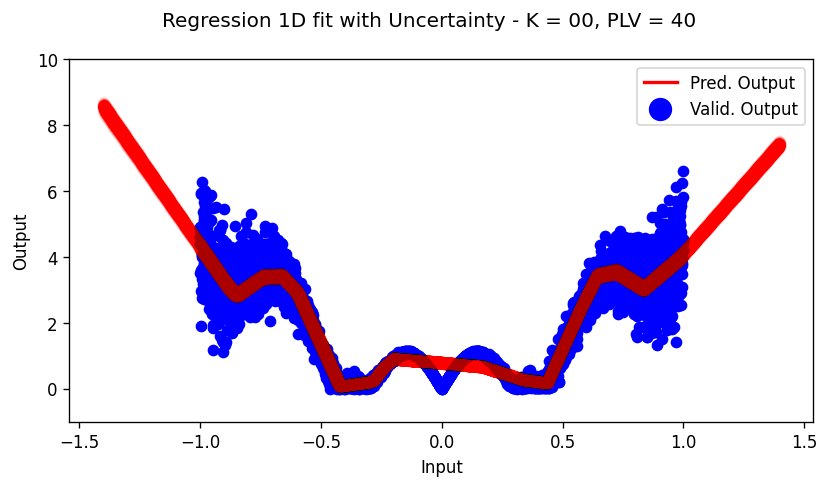

In [115]:
plot_regression(K='00', PLV='40')

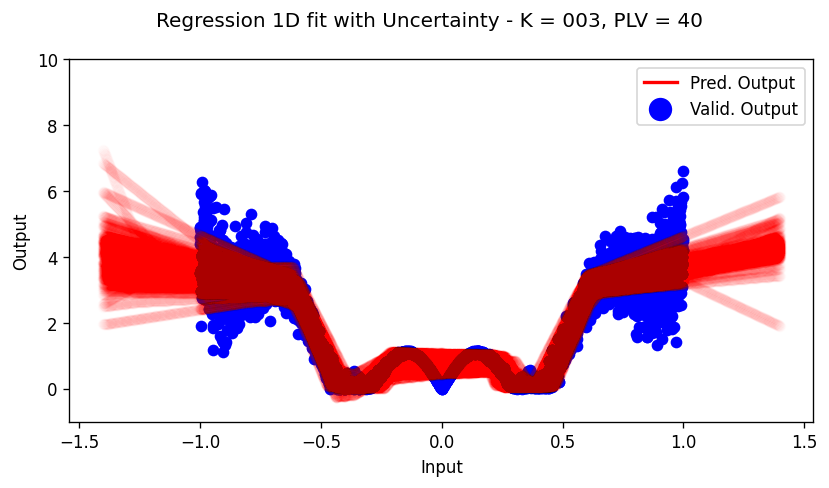

In [114]:
plot_regression(K='003', PLV='40')

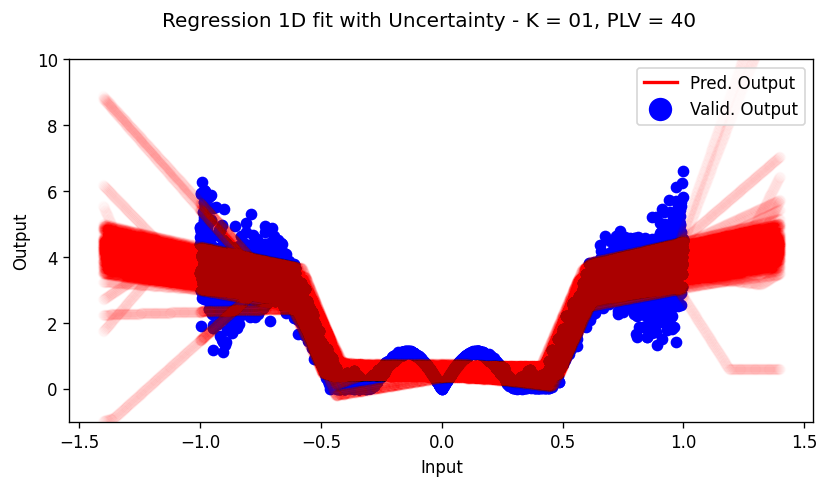

In [113]:
plot_regression(K='01', PLV='40')

In [97]:
def profit(order, sell_price, cost_price):
    return sell_price*torch.minimum(order, demand_true) - cost_price*order

def newsvendor_curve(K, PLV, M=1000):

    model = h_opt_dict[f'{K}_{PLV}']
    
    sp = 200

    zEypred_list = []
    zypred_list = []
    zy_list = []
    cp_list = list(np.arange(20,190,10))
    qtl_list = []

    for cp in cp_list:

        # Classical newsvendor problem
        sell_price = torch.tensor(sp)
        cost_price = torch.tensor(cp)
        quantile_cut = (sell_price - cost_price)/sell_price
        optimal_pred_order = torch.quantile(
            generate_demand_pred_dist(model, M), 
            quantile_cut, dim=0)
        optimal_order = demand_true

        zypred = round(profit(
            optimal_pred_order, 
            sell_price, cost_price
        ).sum().item(), 2)

        zy = round(profit(
            optimal_order, 
            sell_price, cost_price
        ).sum().item(), 2)

        qtl_list.append(quantile_cut.item())

        zypred_list.append((zy-zypred)/zy)

    return qtl_list, zypred_list

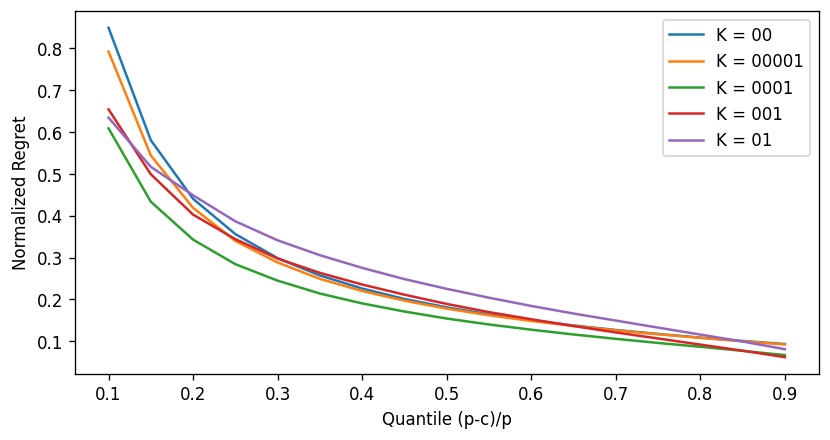

In [98]:
fig, ax = plt.subplots(figsize=(8,4), dpi=120)
ax.set_xlabel('Quantile (p-c)/p')
ax.set_ylabel('Normalized Regret')

for kk in ['00', '00001', '0001', '001', '01']:
    qtl_list, zypred_list = newsvendor_curve(K=f'{kk}', PLV='00', M=1000)
    ax.plot(qtl_list, zypred_list, label = f'K = {kk}')
    ax.legend()

In [99]:
def compute_normalized_regret(K, PLV, M=1000, sell_price = 200, cost_price = 150):

    model = h_opt_dict[f'{K}_{PLV}']

    quantile_cut = (sell_price - cost_price)/sell_price

    optimal_pred_order = torch.quantile(
                generate_demand_pred_dist(model, M), 
                quantile_cut, dim=0)

    optimal_order = demand_true

    zypred = round(profit(
                optimal_pred_order, 
                sell_price, cost_price
            ).sum().item(), 2)

    zy = round(profit(
        optimal_order, 
        sell_price, cost_price
    ).sum().item(), 2)

    normalized_regret = (zy-zypred)/zy
    
    return normalized_regret

In [100]:
sell_price = 200
cost_price = 40

k_list = ['00', '00001', '00003', '0001', '0003', '001', '003', '01']
plv_list = ['-10', '00', '05', '10', '20', '40']

nrs = np.zeros((len(k_list), len(plv_list)))

for i in range(0, len(k_list)):
    for j in range(0, len(plv_list)):
        nrs[i,j] = compute_normalized_regret(
                        k_list[i], 
                        plv_list[j], 
                        M=1000,
                        sell_price=sell_price, 
                        cost_price=cost_price)

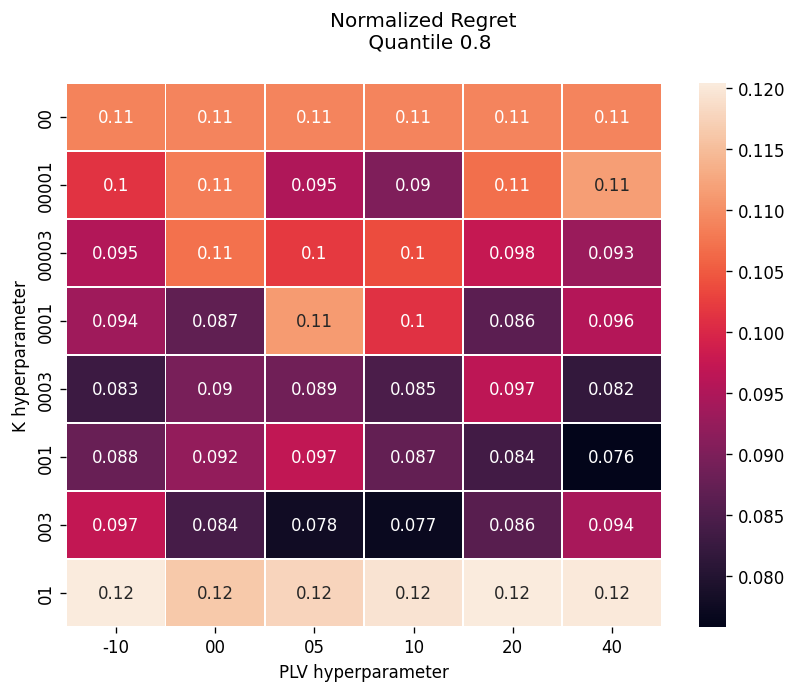

In [101]:

fig, ax = plt.subplots(figsize=(8,6),dpi=120)
ax = sns.heatmap(nrs, linewidth=0.5, xticklabels=plv_list, yticklabels=k_list, annot=True)
fig.suptitle(f'Normalized Regret \n Quantile {(sell_price - cost_price)/sell_price}')
ax.set_ylabel('K hyperparameter')
ax.set_xlabel('PLV hyperparameter')

plt.show()